In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

from sbatch_pred.queuetime_prediction.model_training import partition_clusters

pd.set_option('display.max_rows', 100)

In [2]:
results_fp = '../../data/results/xgb_cls_combined_pred_results.parquet'
results_df = pd.read_parquet(results_fp)

In [3]:
def get_accuracy(df, adjacent=False):
    if adjacent:
        return len(df[(df.cluster_pred == df.cluster - 1) |
                   (df.cluster_pred == df.cluster) |
                   (df.cluster_pred == df.cluster + 1)]) / len(df.cluster)
    return len(df[df.cluster_pred == df.cluster]) / len(df.cluster)

In [4]:
print(f'Total Accuracy: {get_accuracy(results_df, True):.3f}')

Total Accuracy: 0.594


In [5]:
print('='*33)
print('Accuracy'.center(33))
print('='*33)
for partition in results_df.partition.unique():
    df = results_df[results_df.partition == partition]
    accuracy = get_accuracy(df, True)
    print(f'{partition.rjust(15)} {accuracy:.3f} ({len(df)} jobs)')

             Accuracy            
       standard 0.520 (283177 jobs)
    short-stdby 0.722 (102739 jobs)
            gpu 0.613 (10436 jobs)
          debug 0.712 (25088 jobs)
          short 0.570 (311242 jobs)
         bigmem 0.861 (8397 jobs)
           off2 0.853 (7653 jobs)
     long-stdby 0.678 (6855 jobs)
           long 0.586 (77291 jobs)
 standard-stdby 0.626 (153576 jobs)
           off1 0.630 (58452 jobs)
    debug-stdby 0.727 (4857 jobs)
     bigscratch 0.233 (30 jobs)
     off1-stdby 0.000 (35 jobs)
           gpul 0.463 (350 jobs)
      gpu-stdby 0.788 (2553 jobs)
   bigmem-stdby 0.009 (869 jobs)


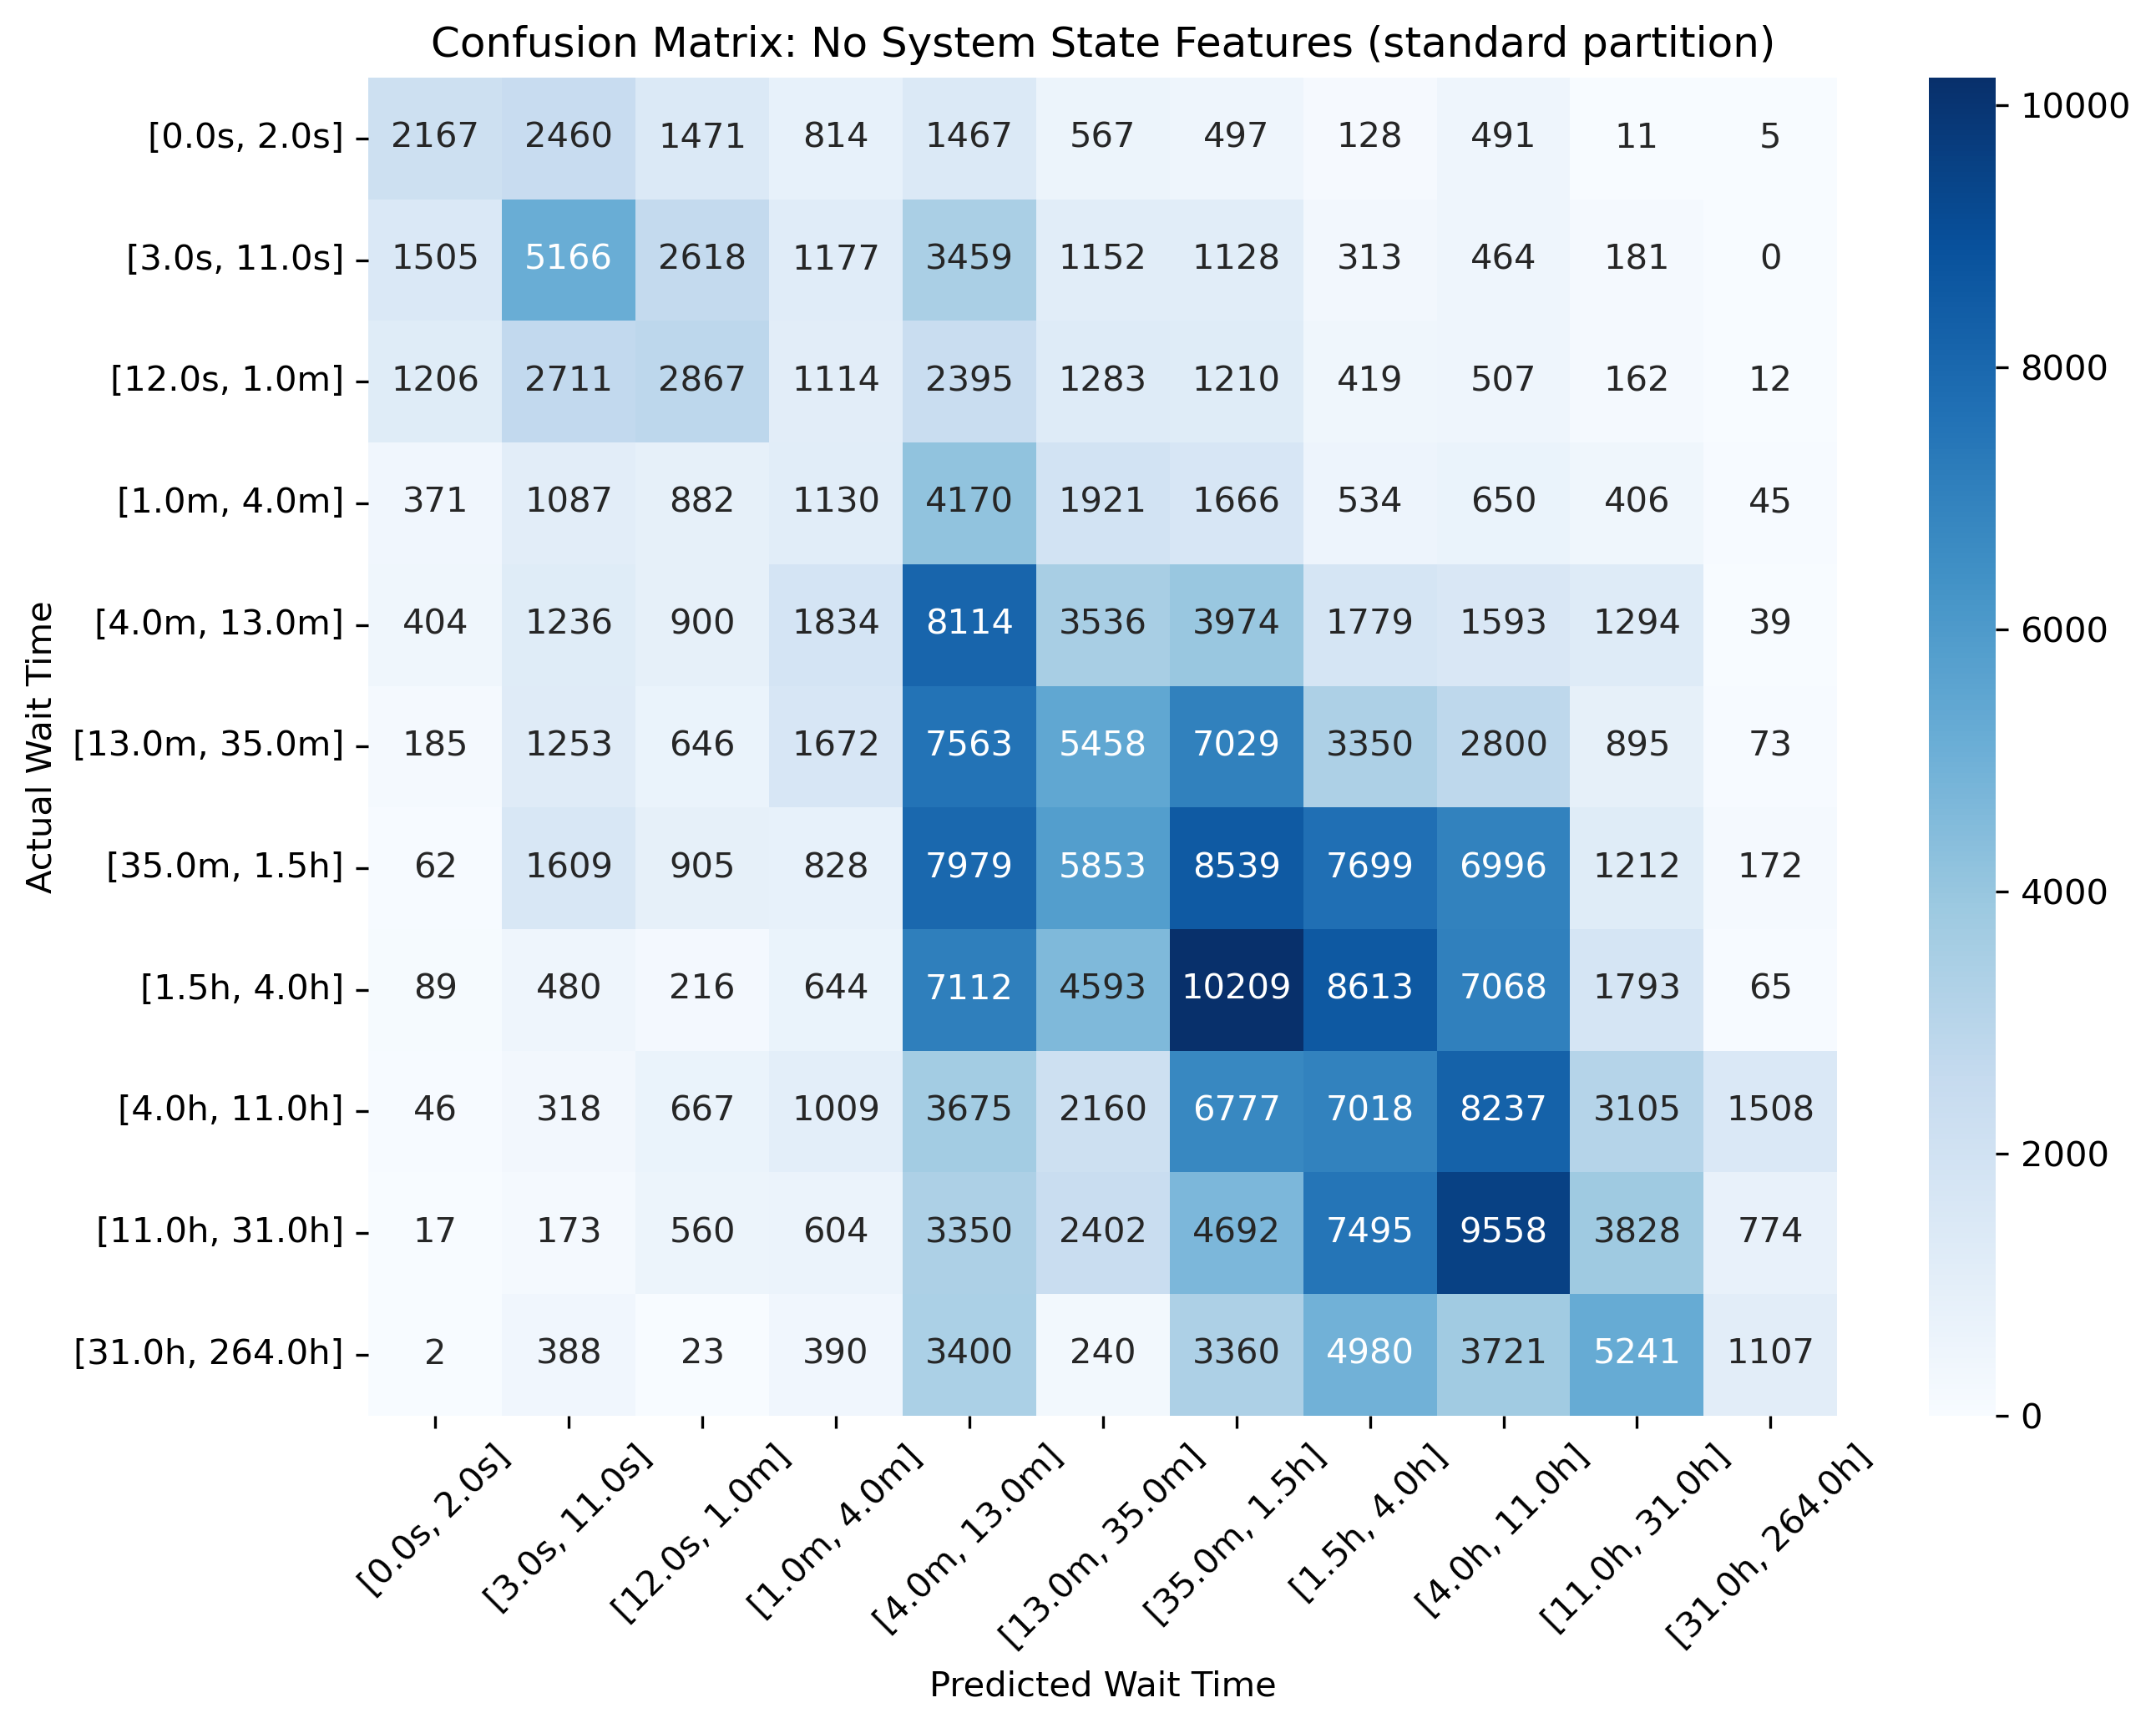

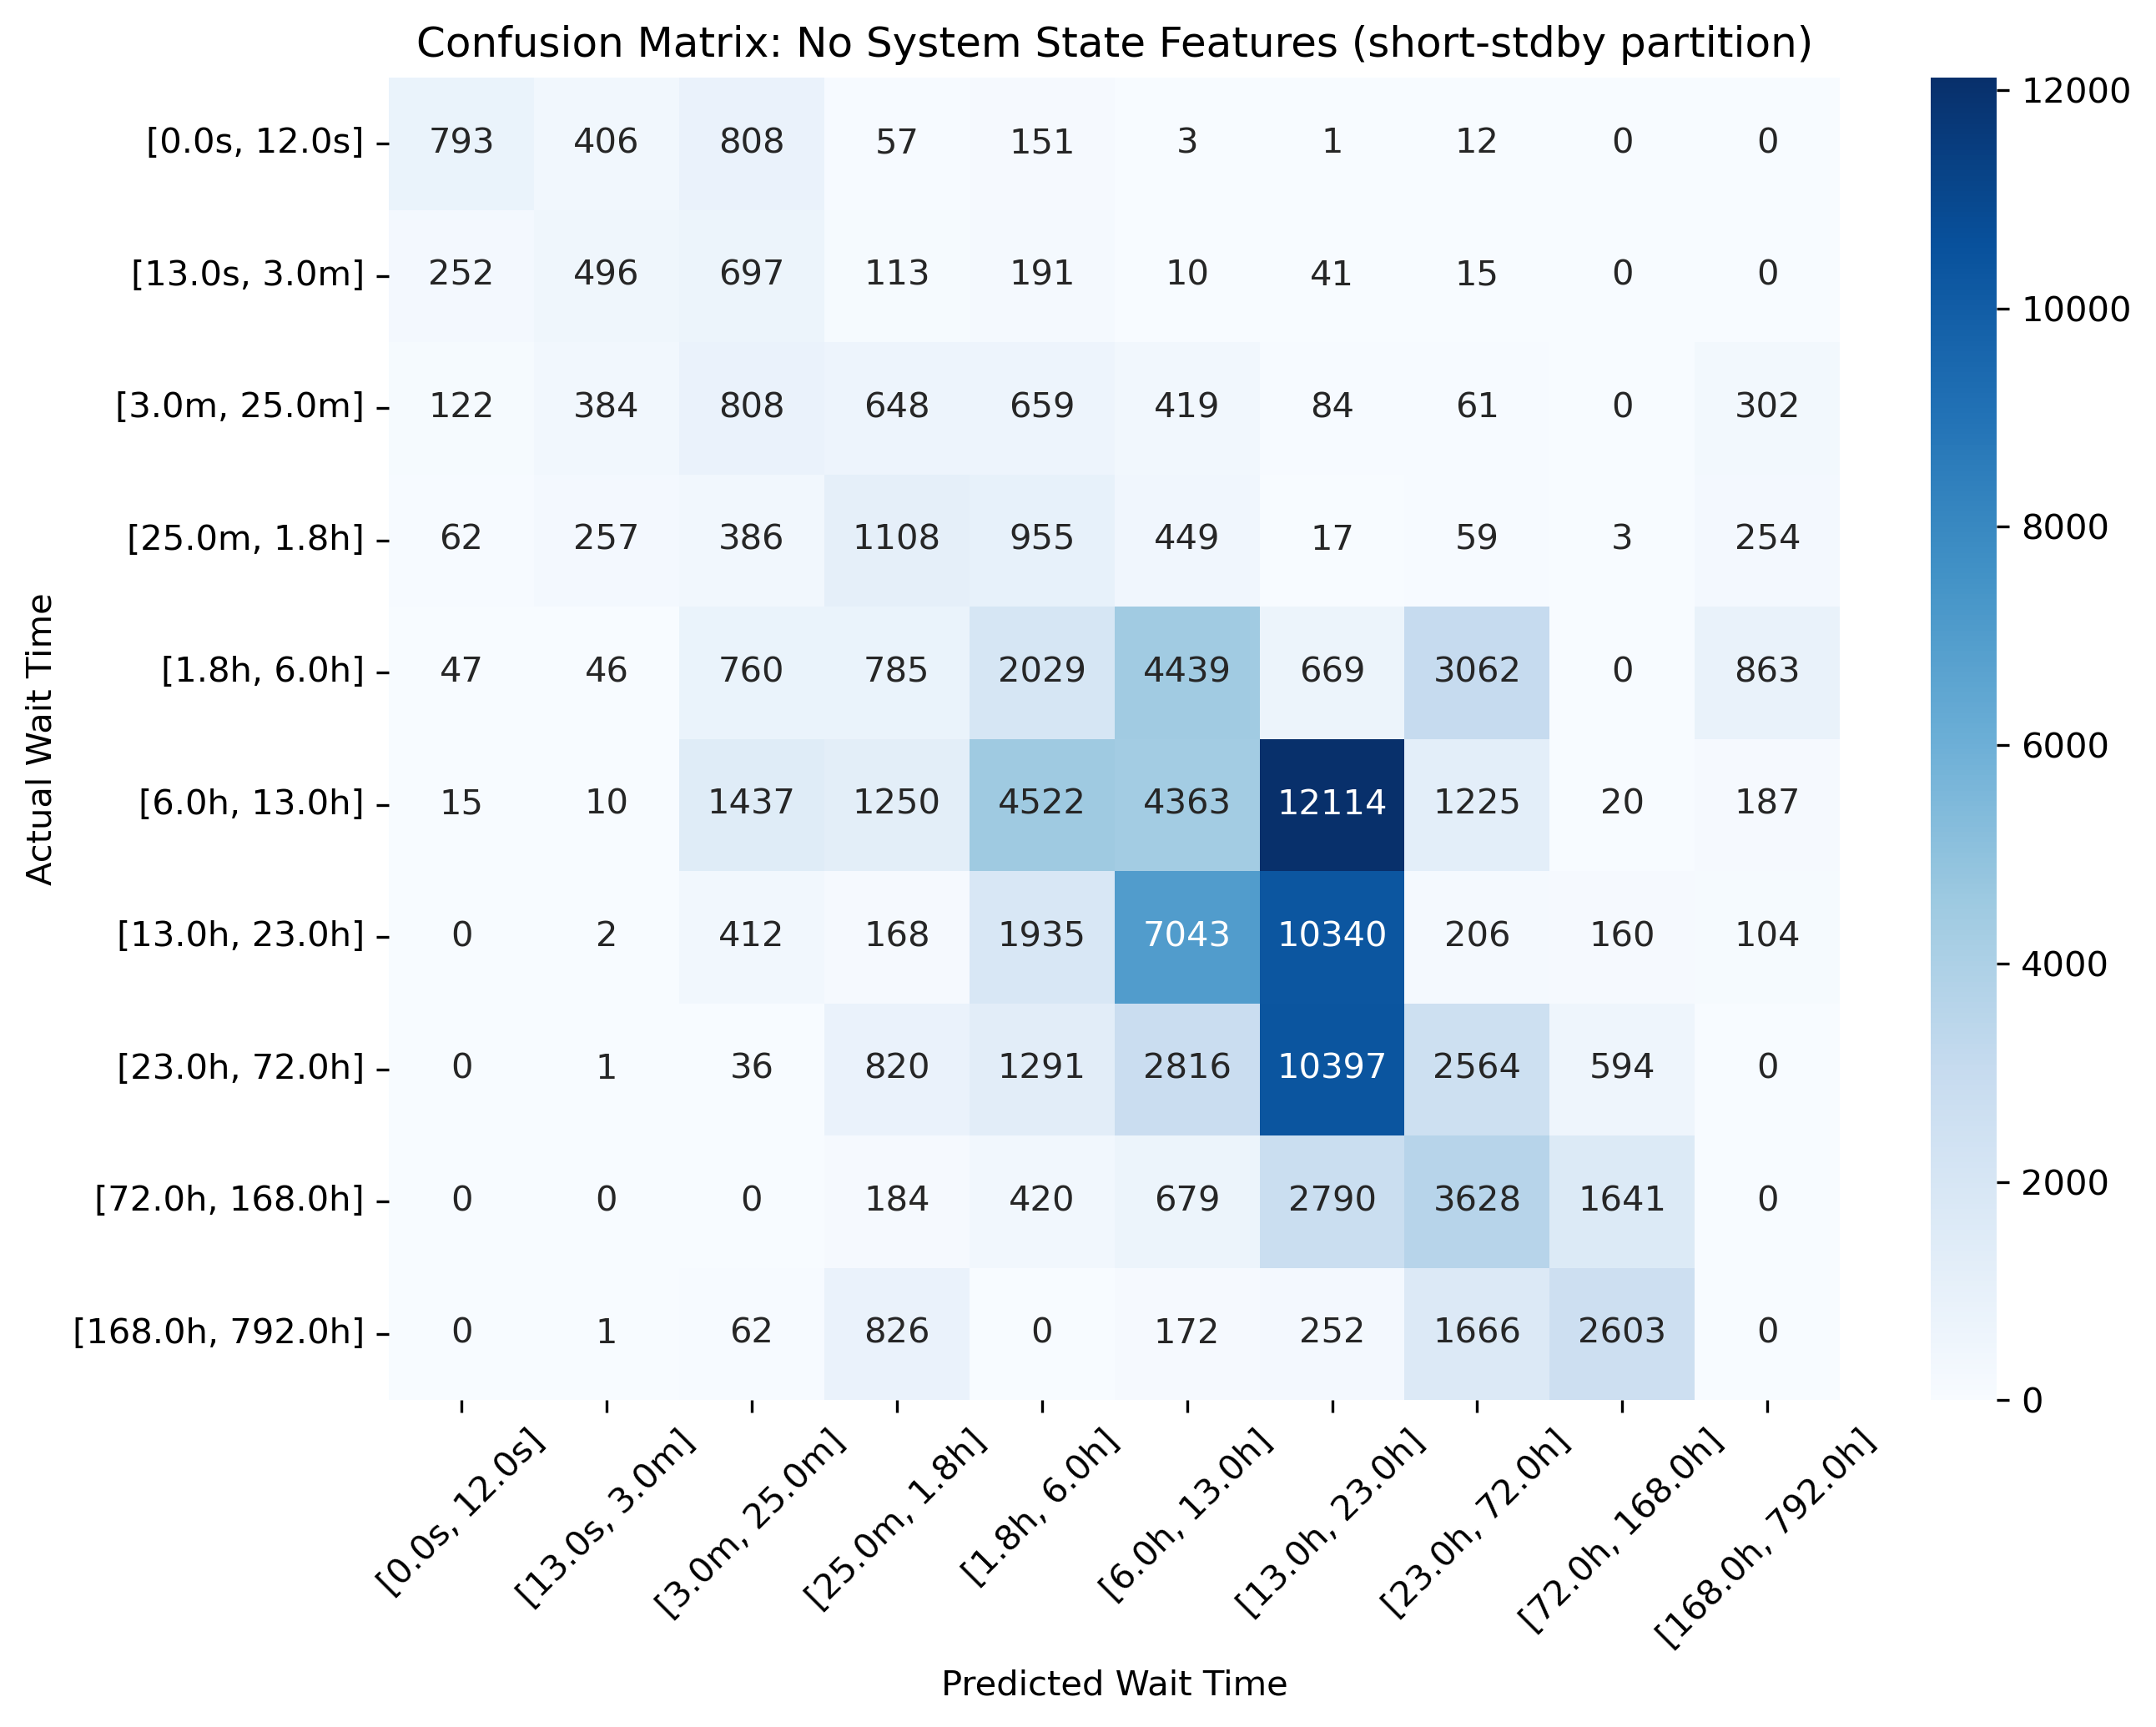

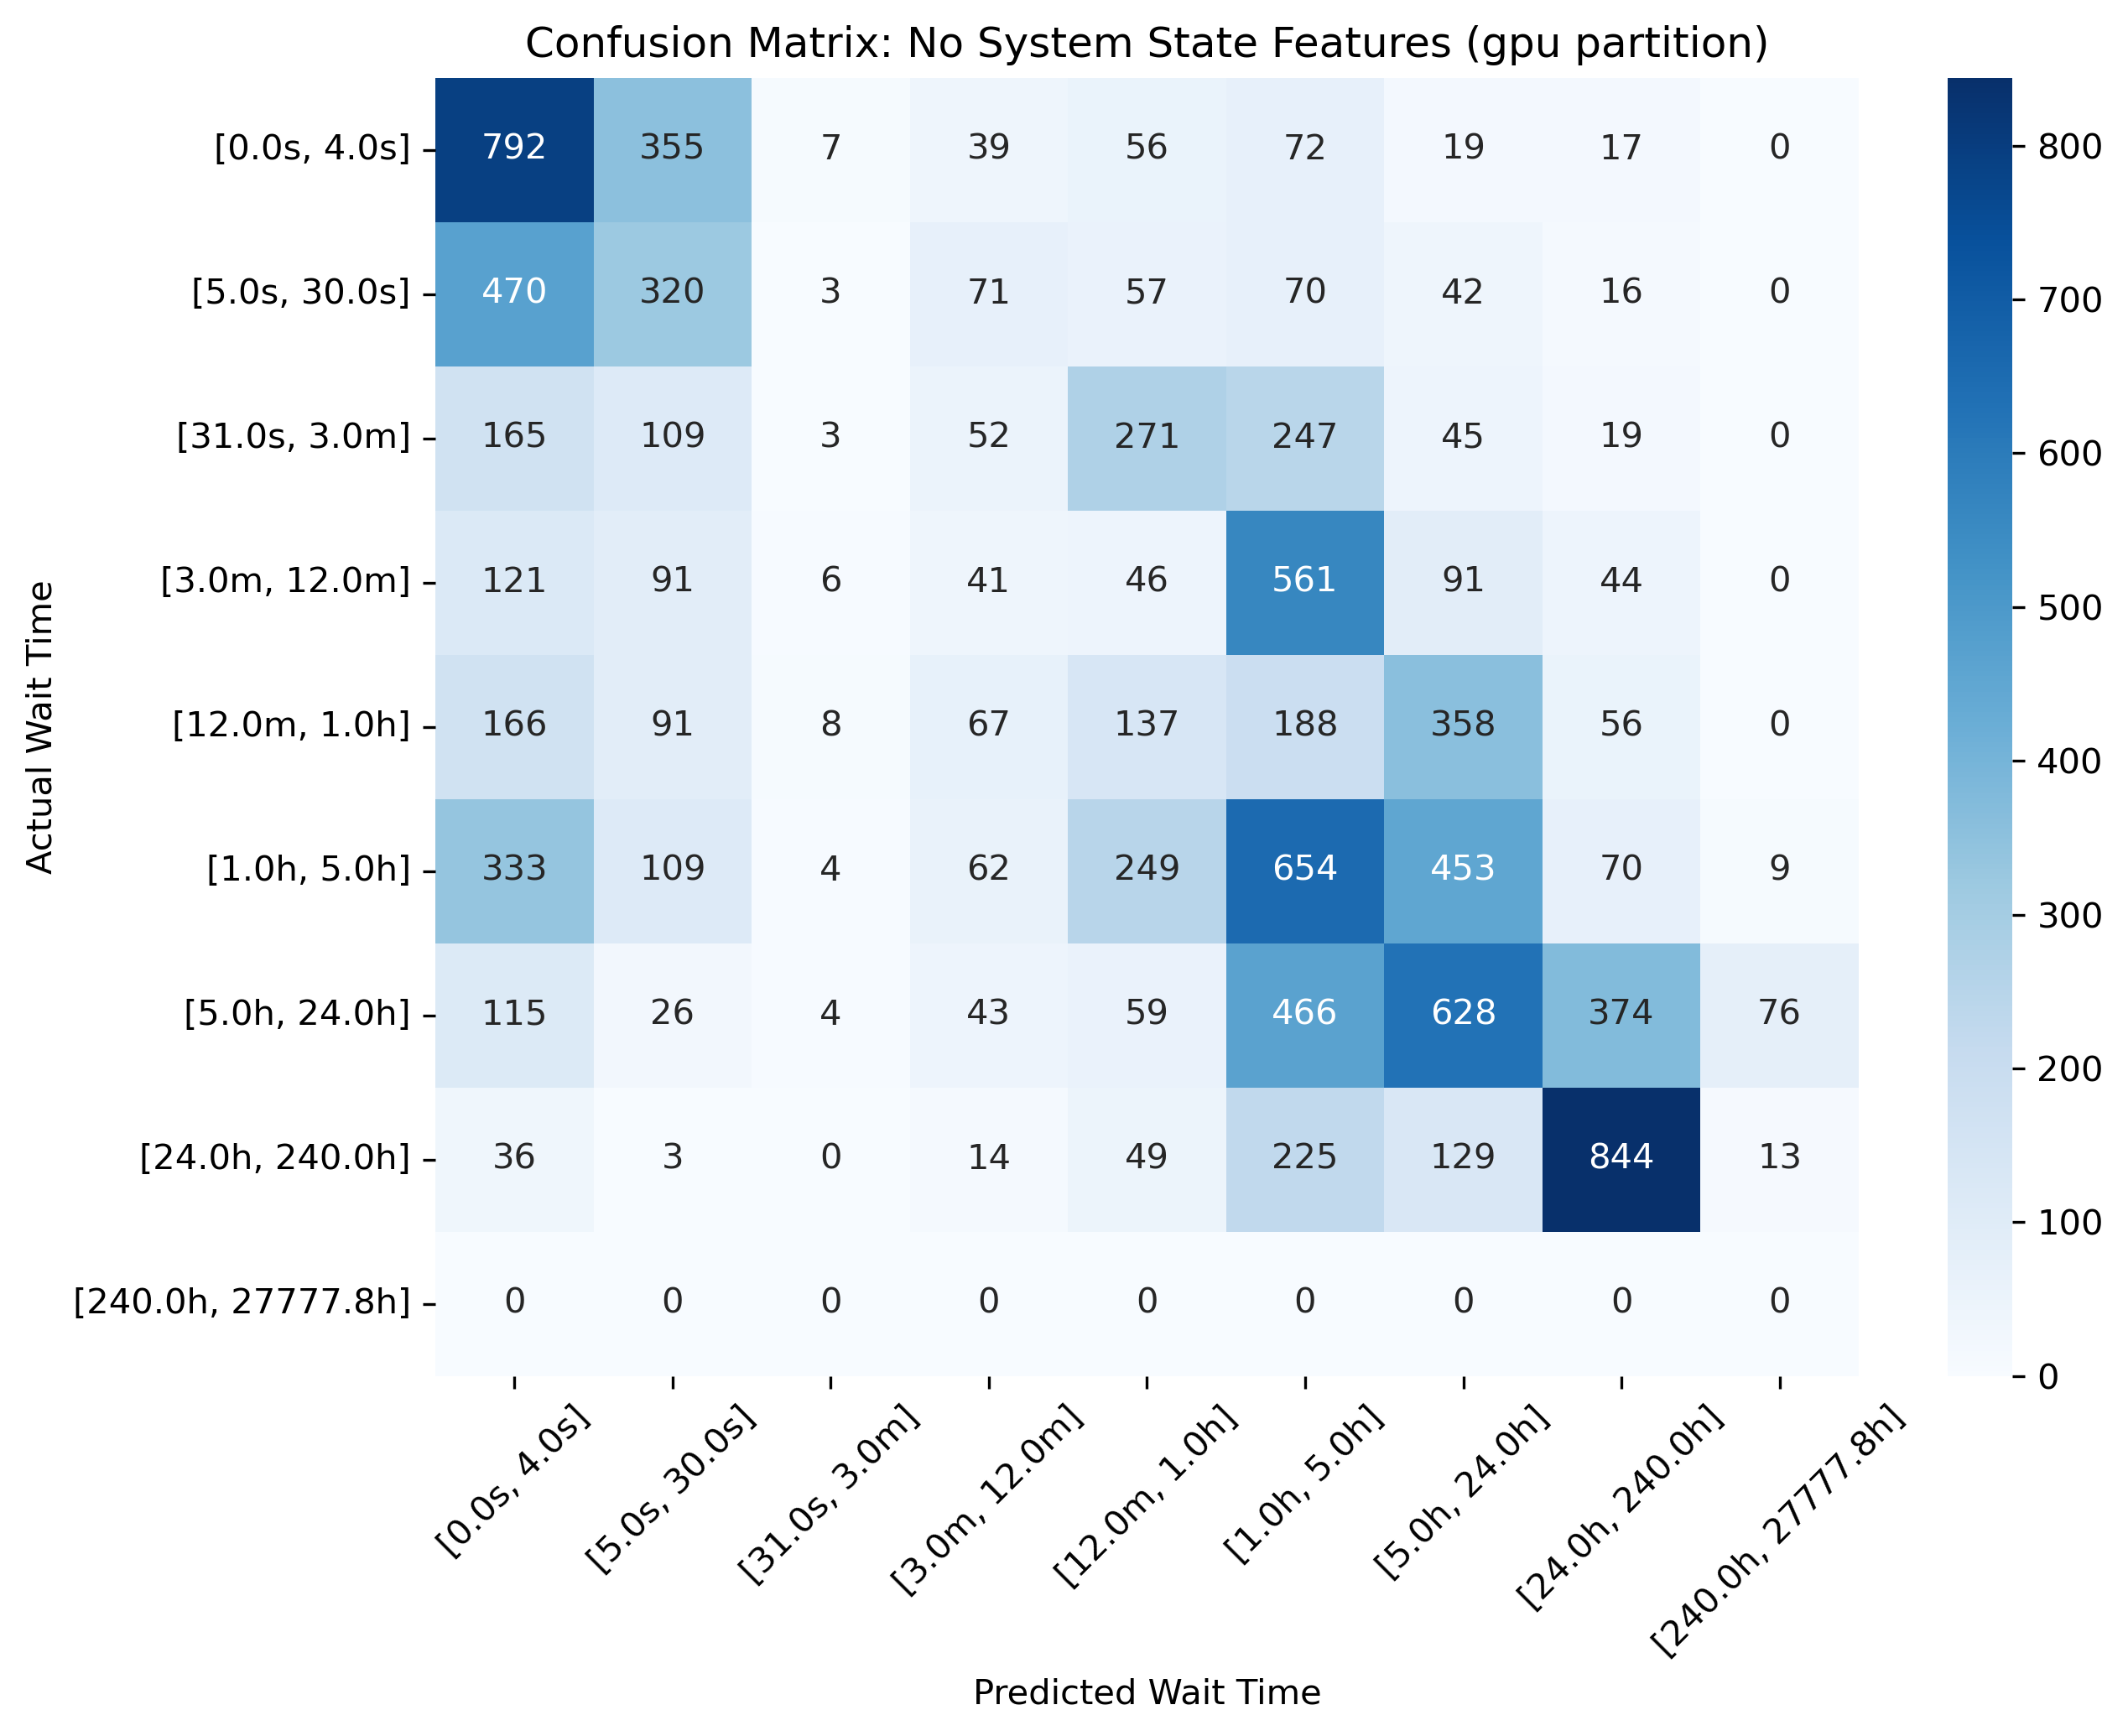

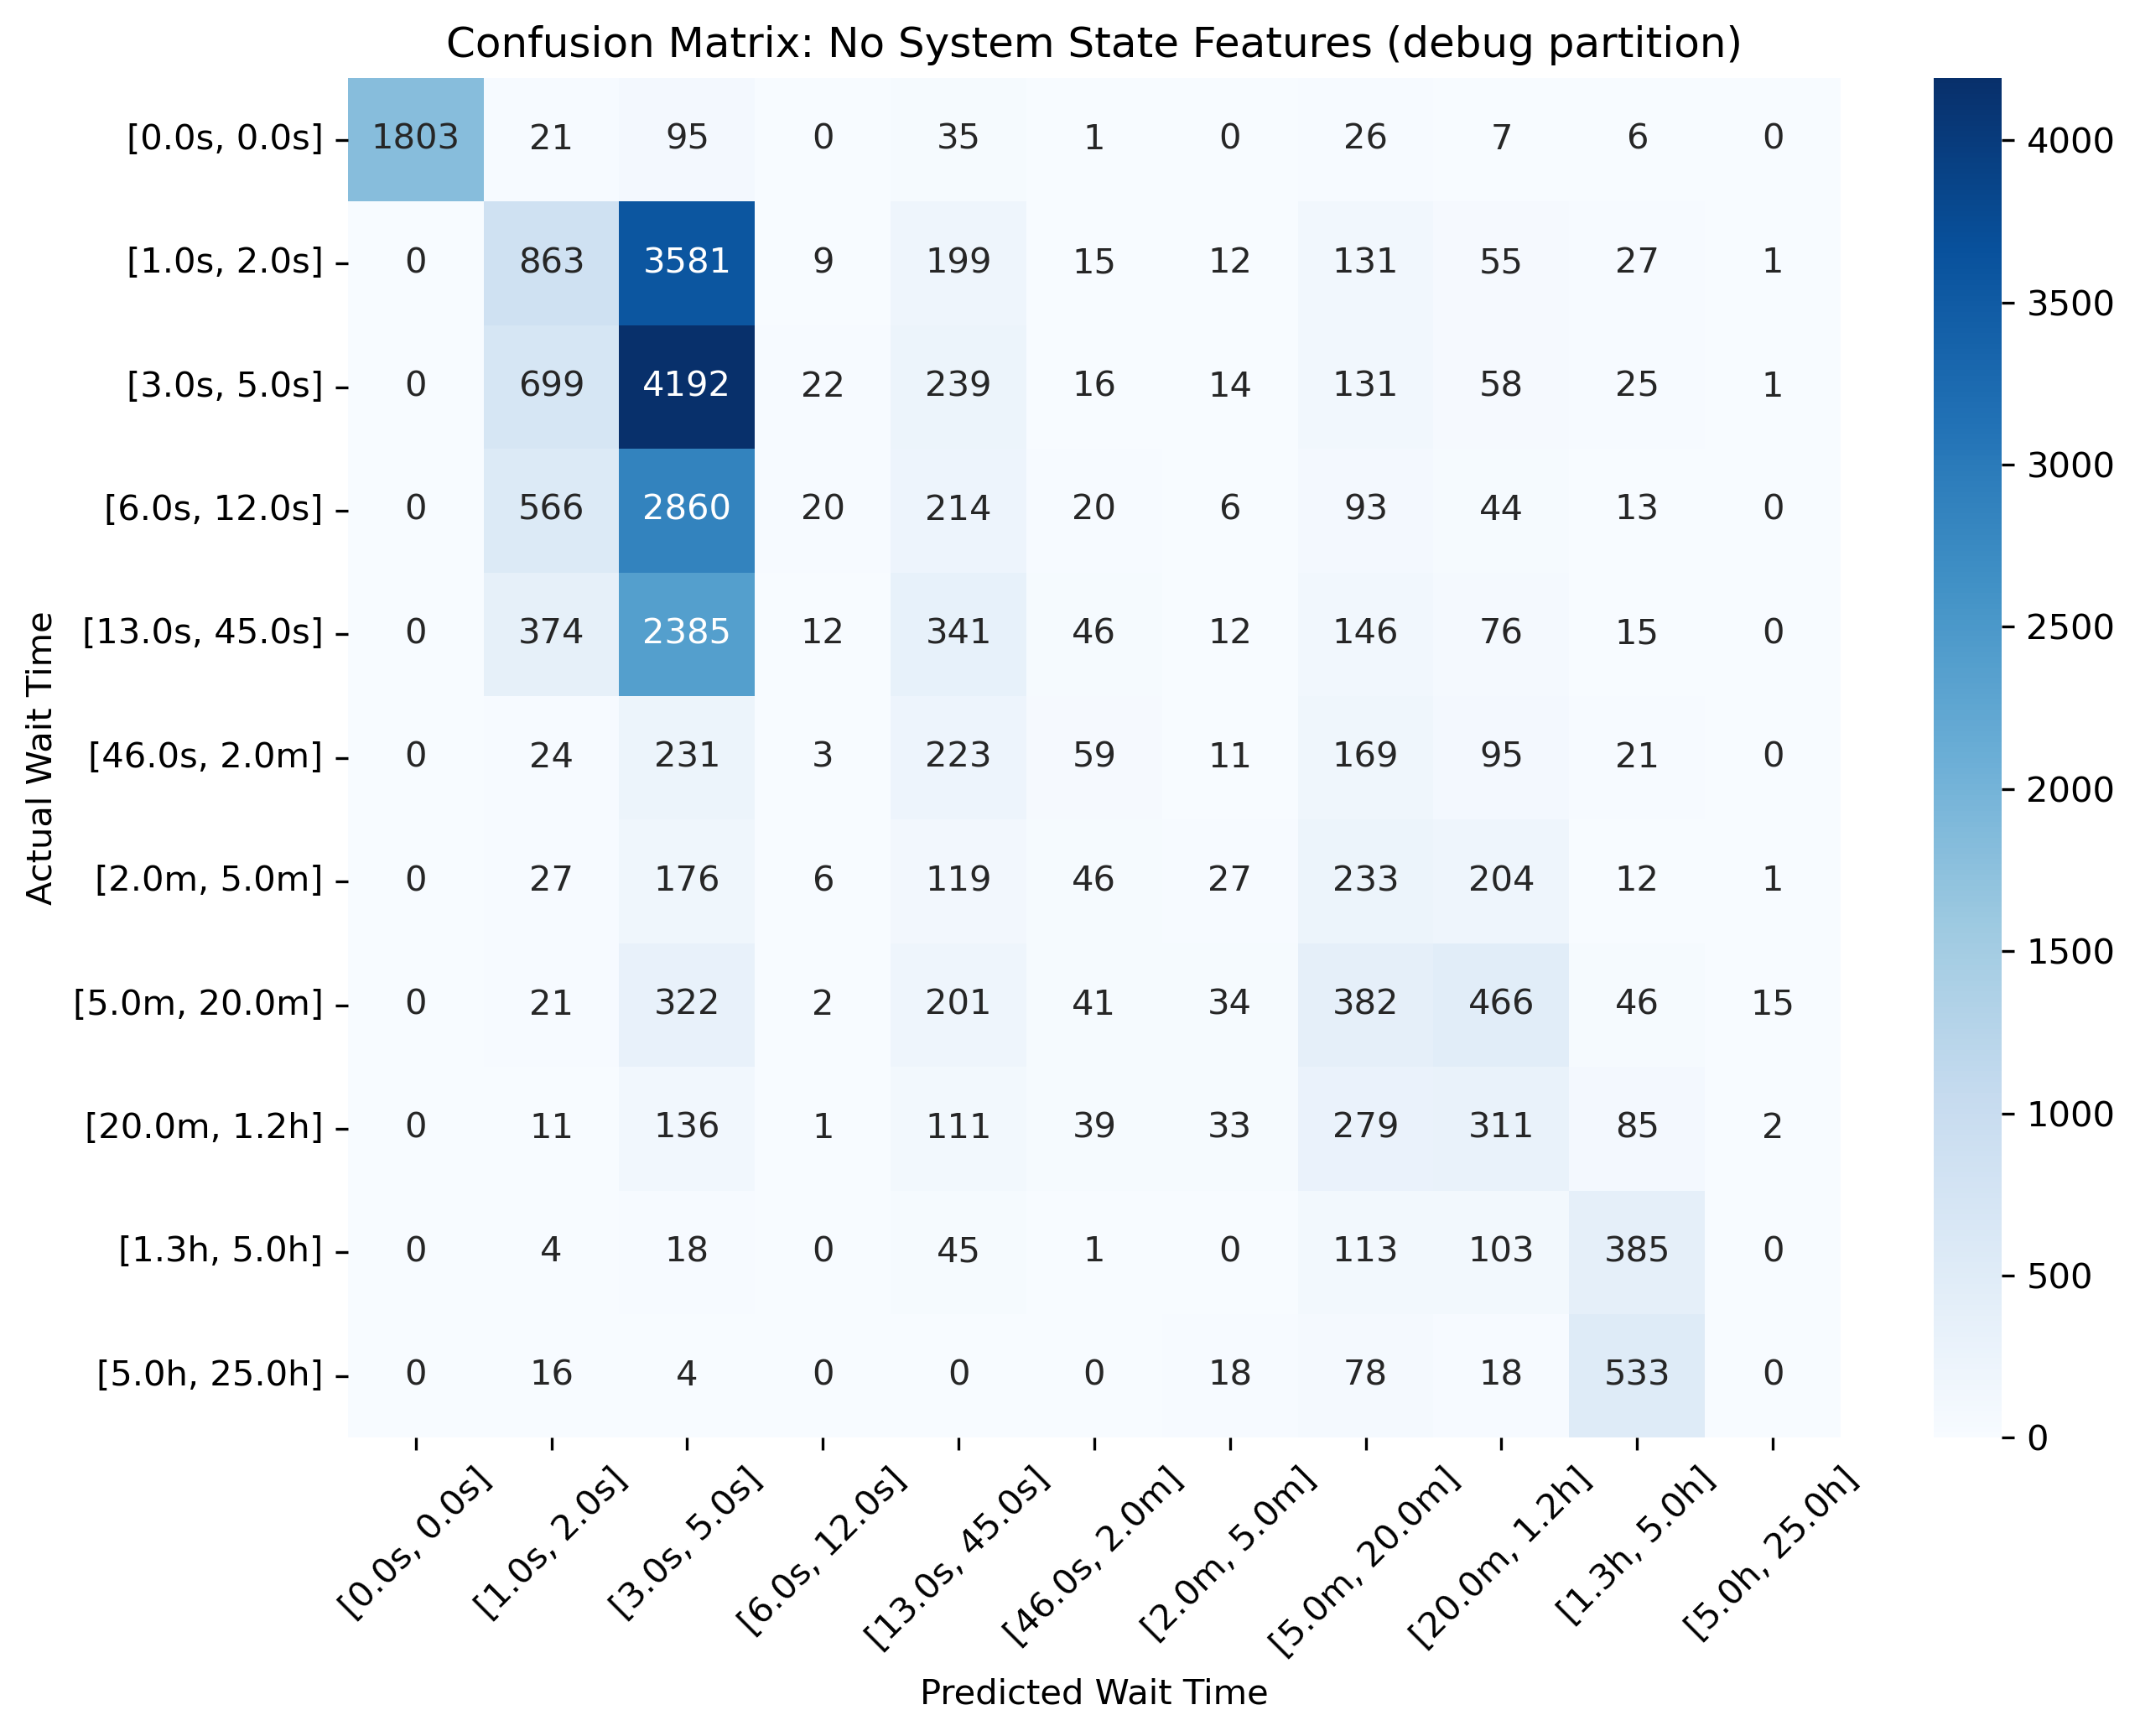

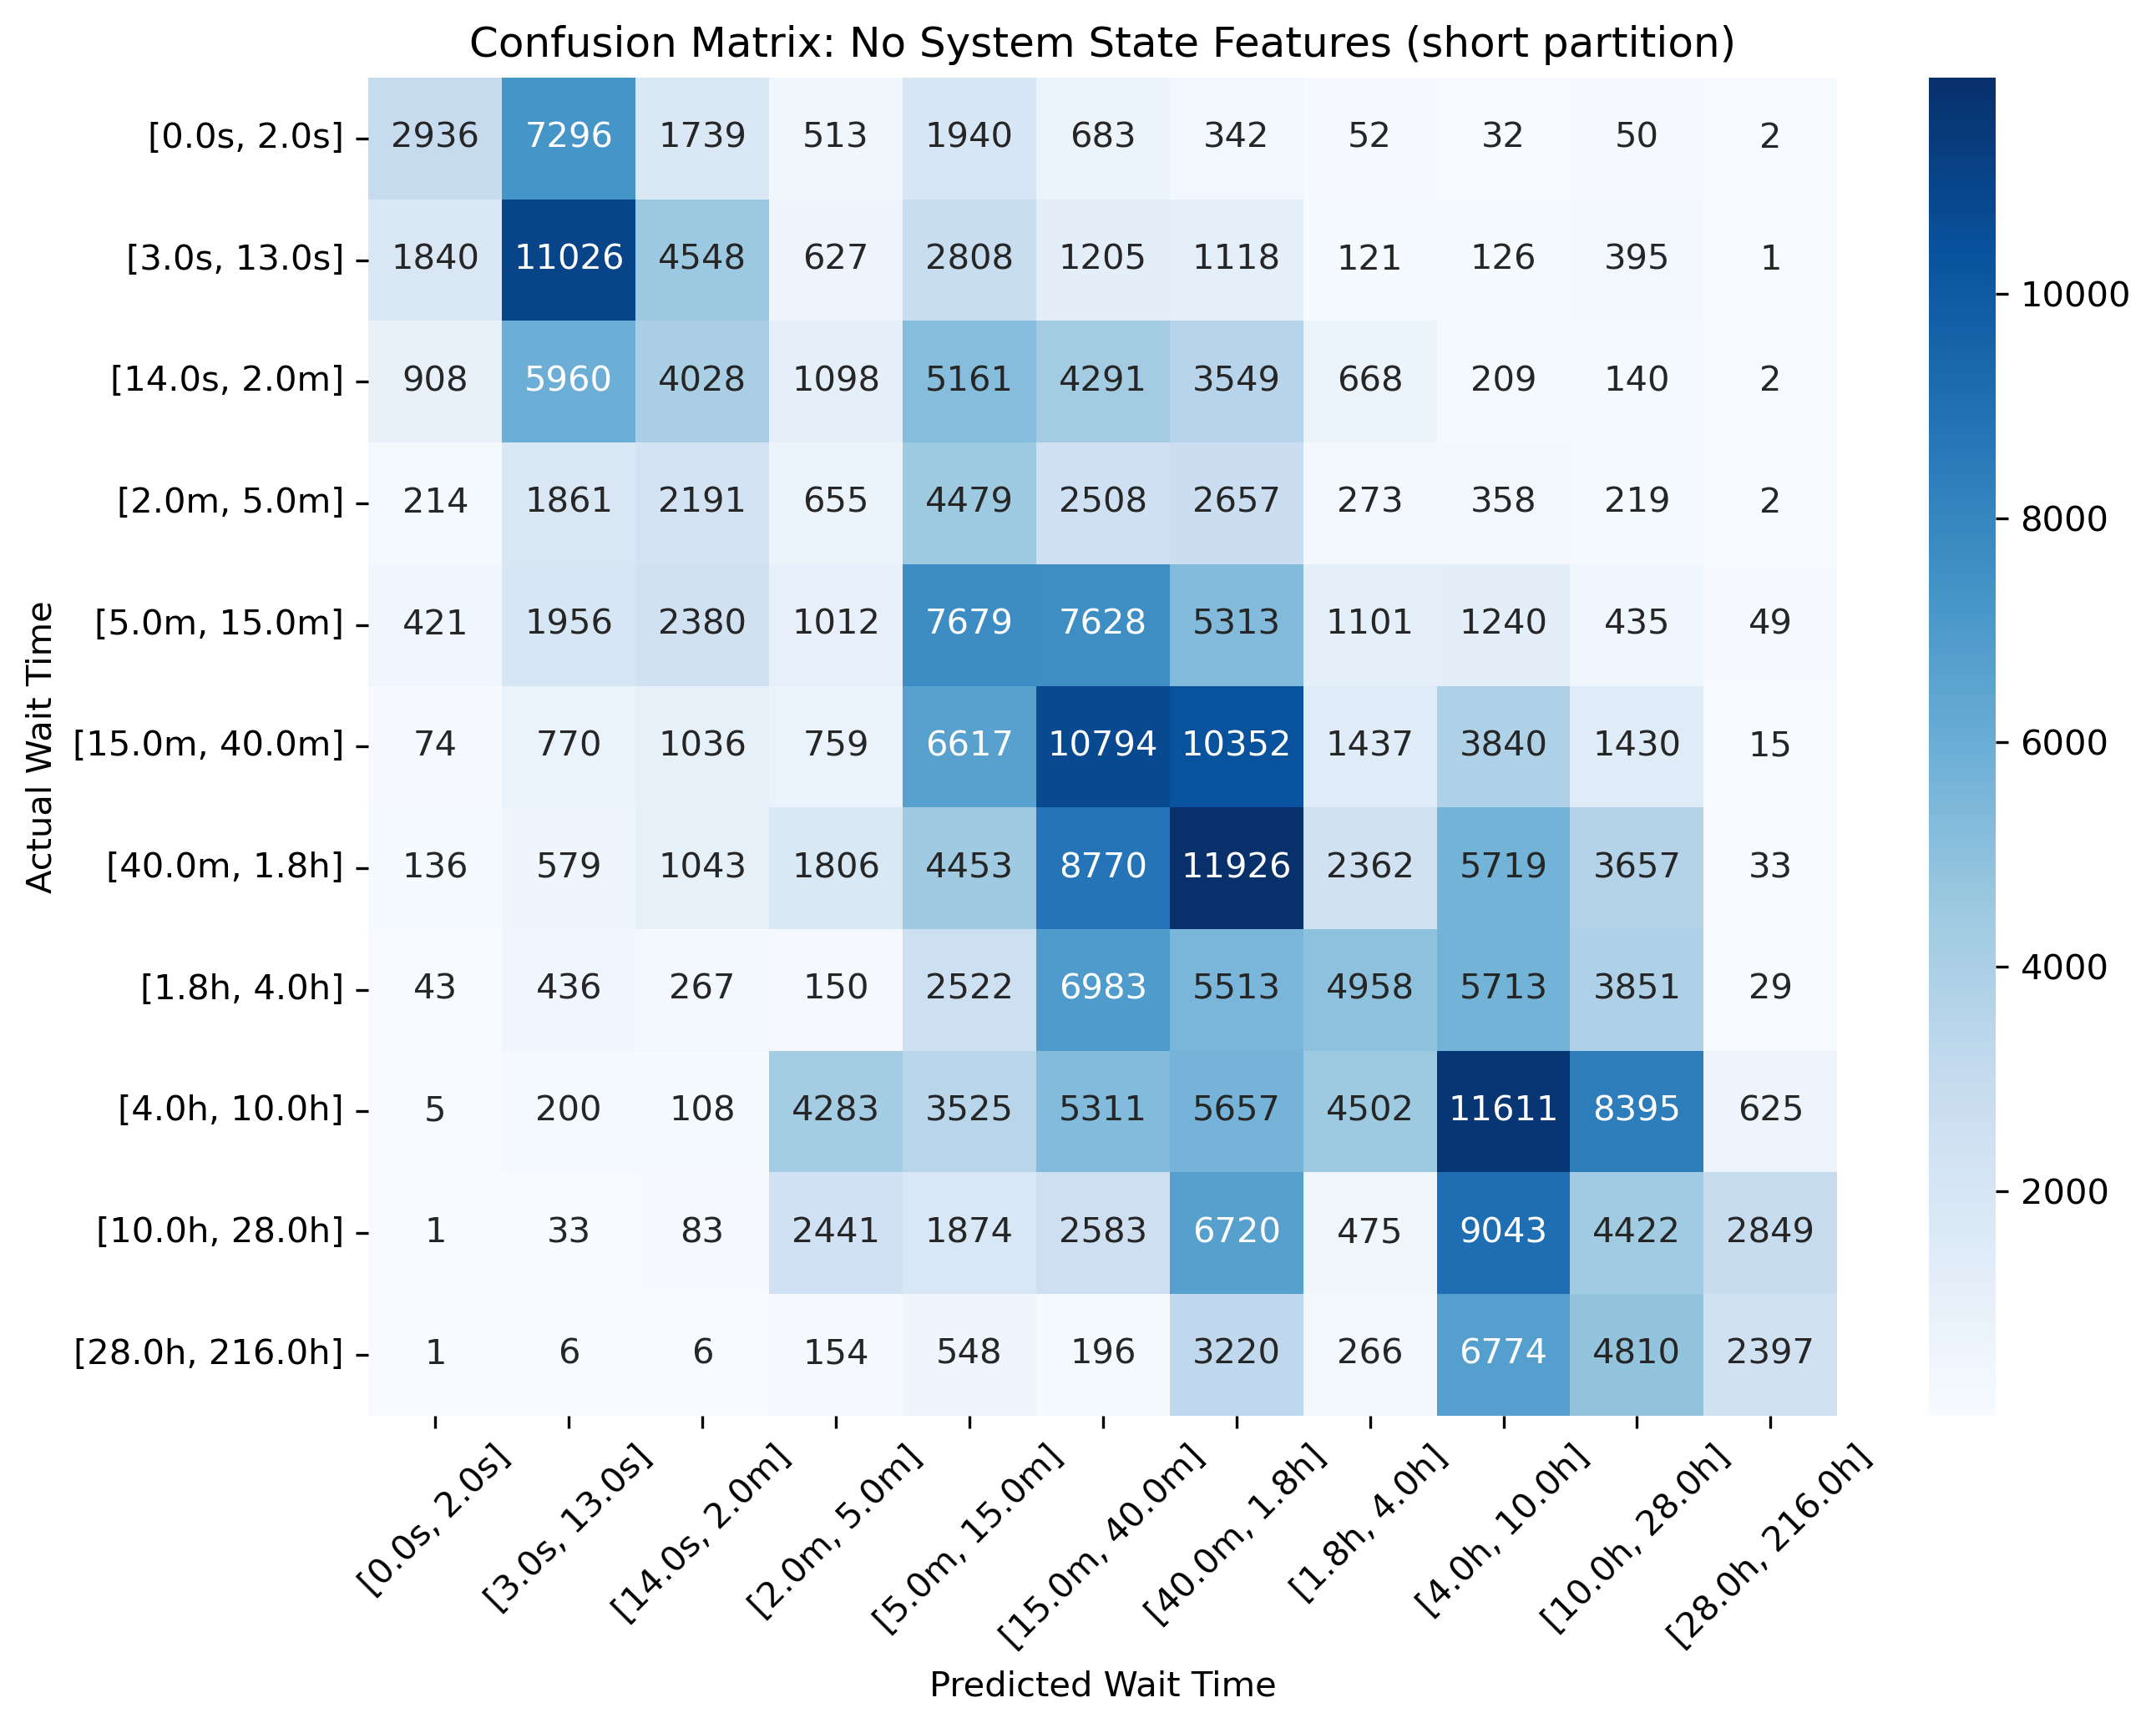

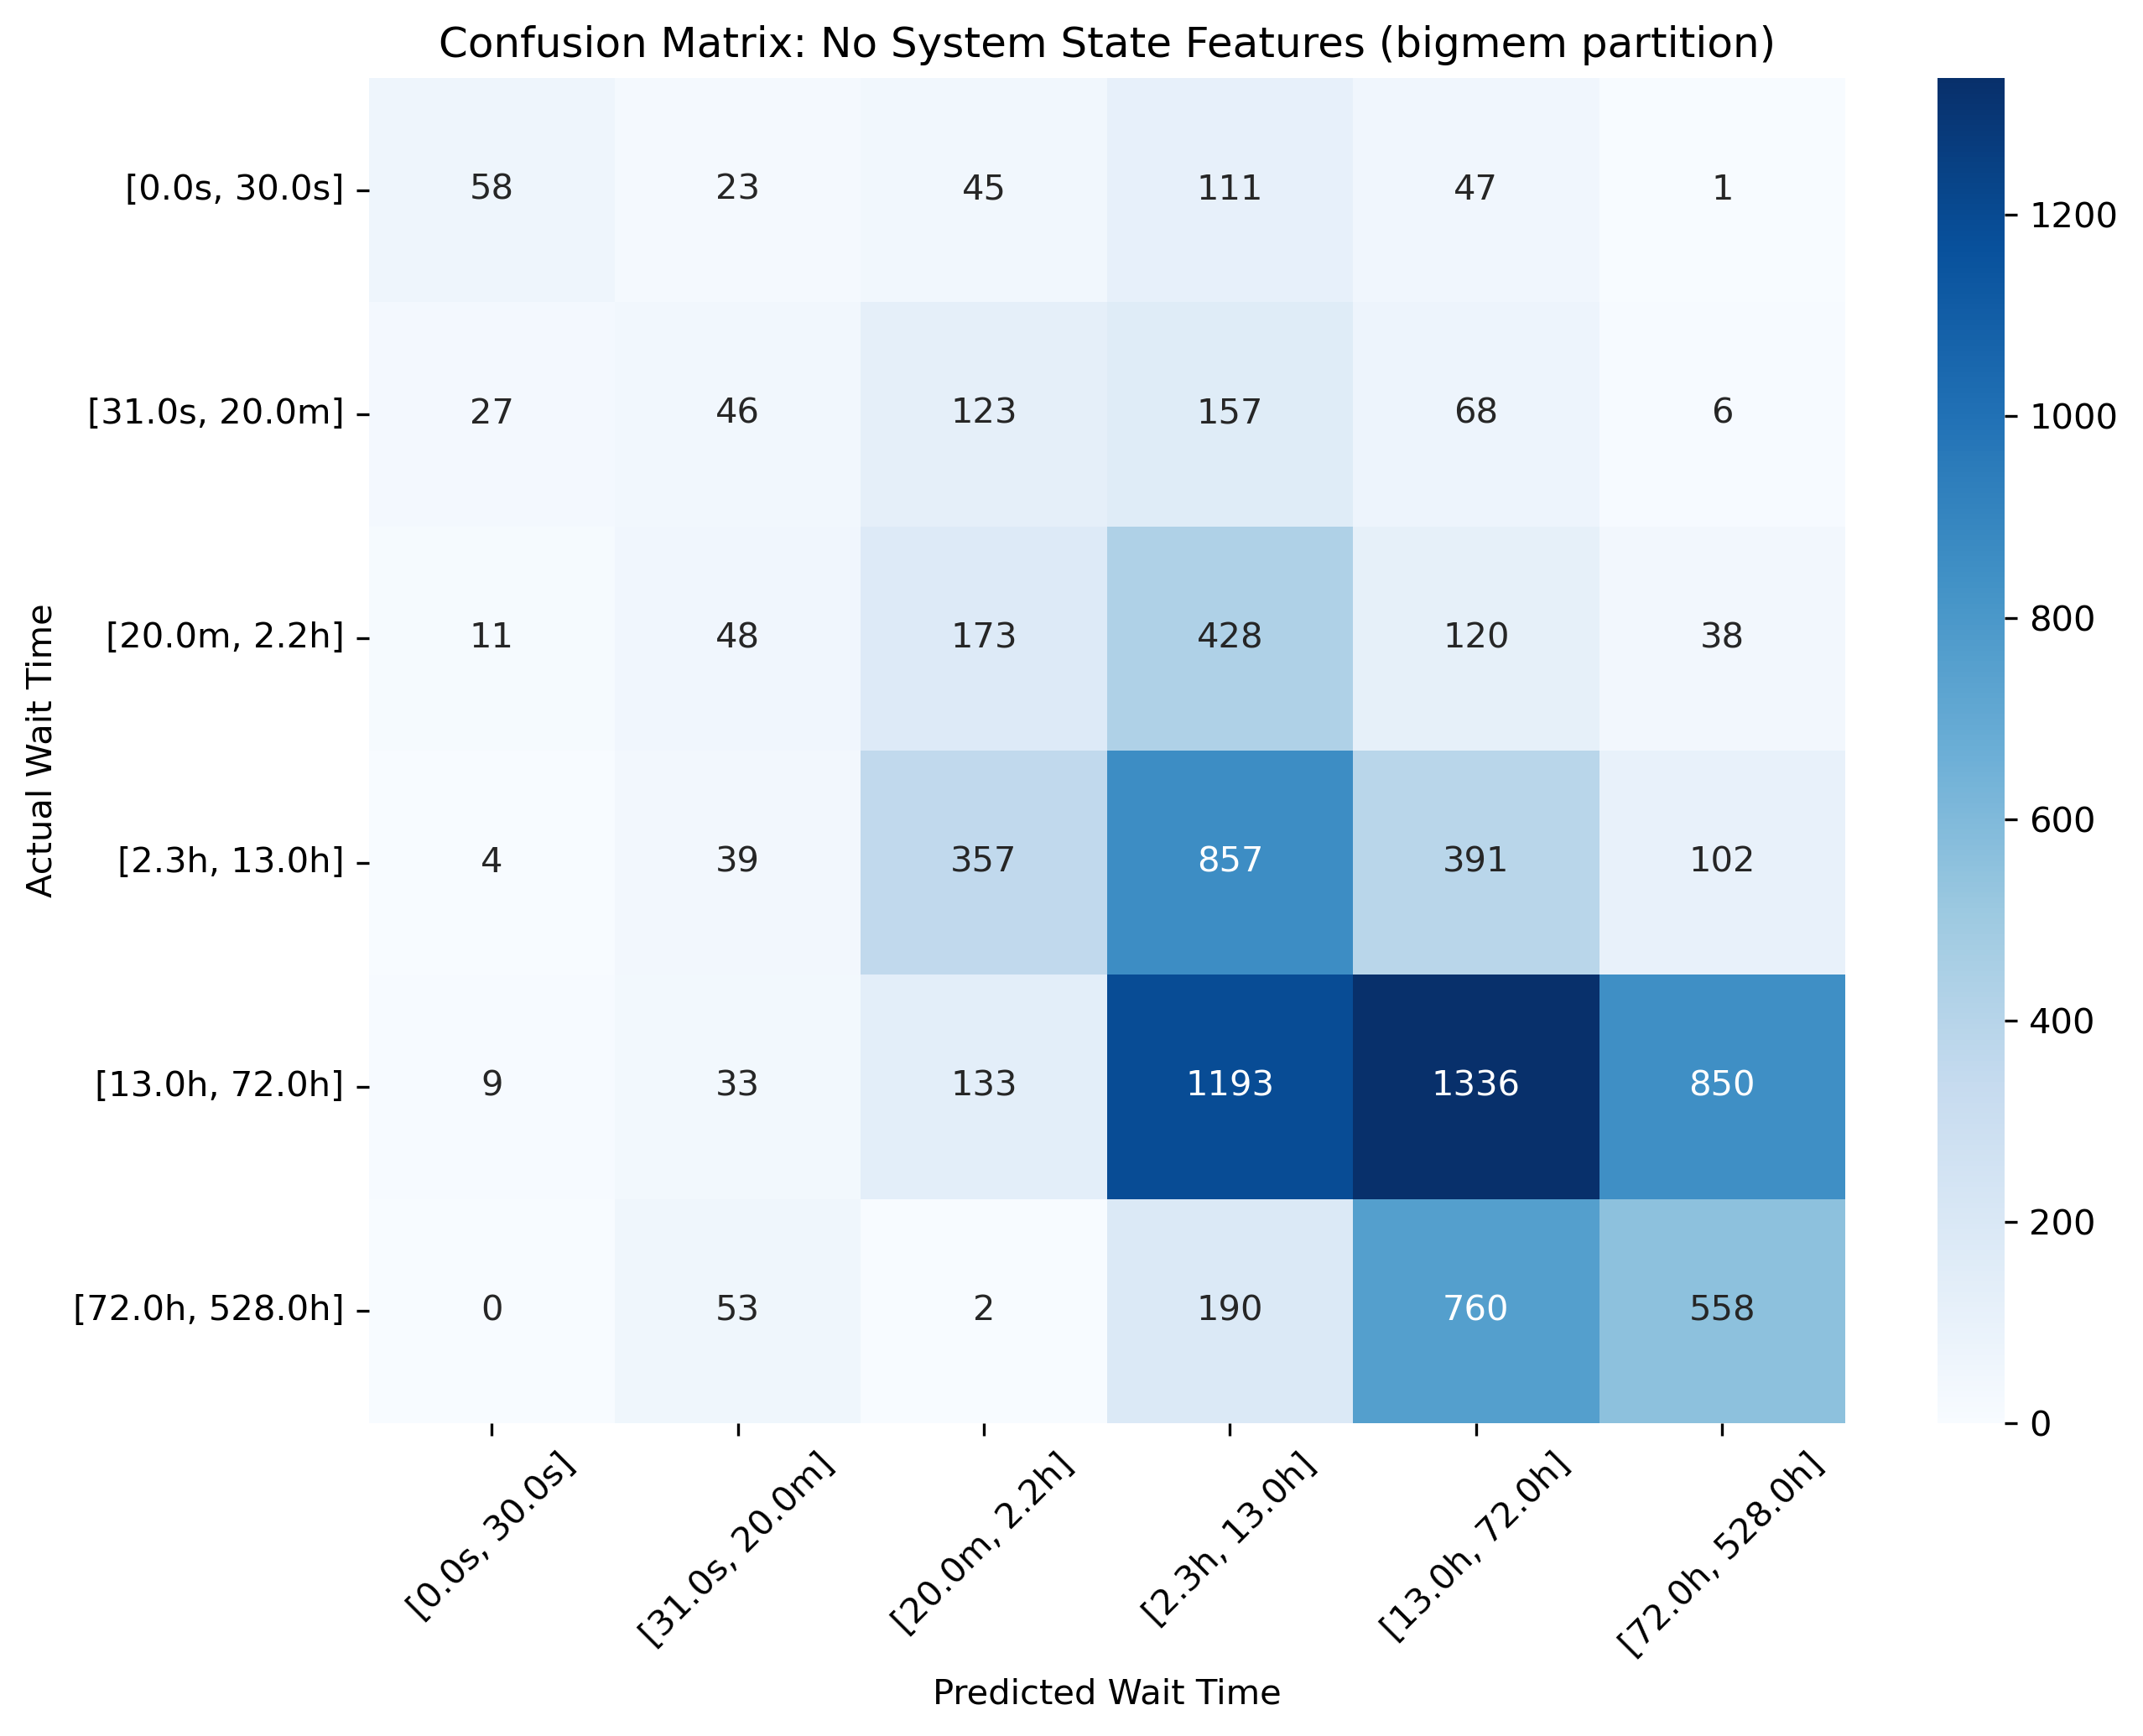

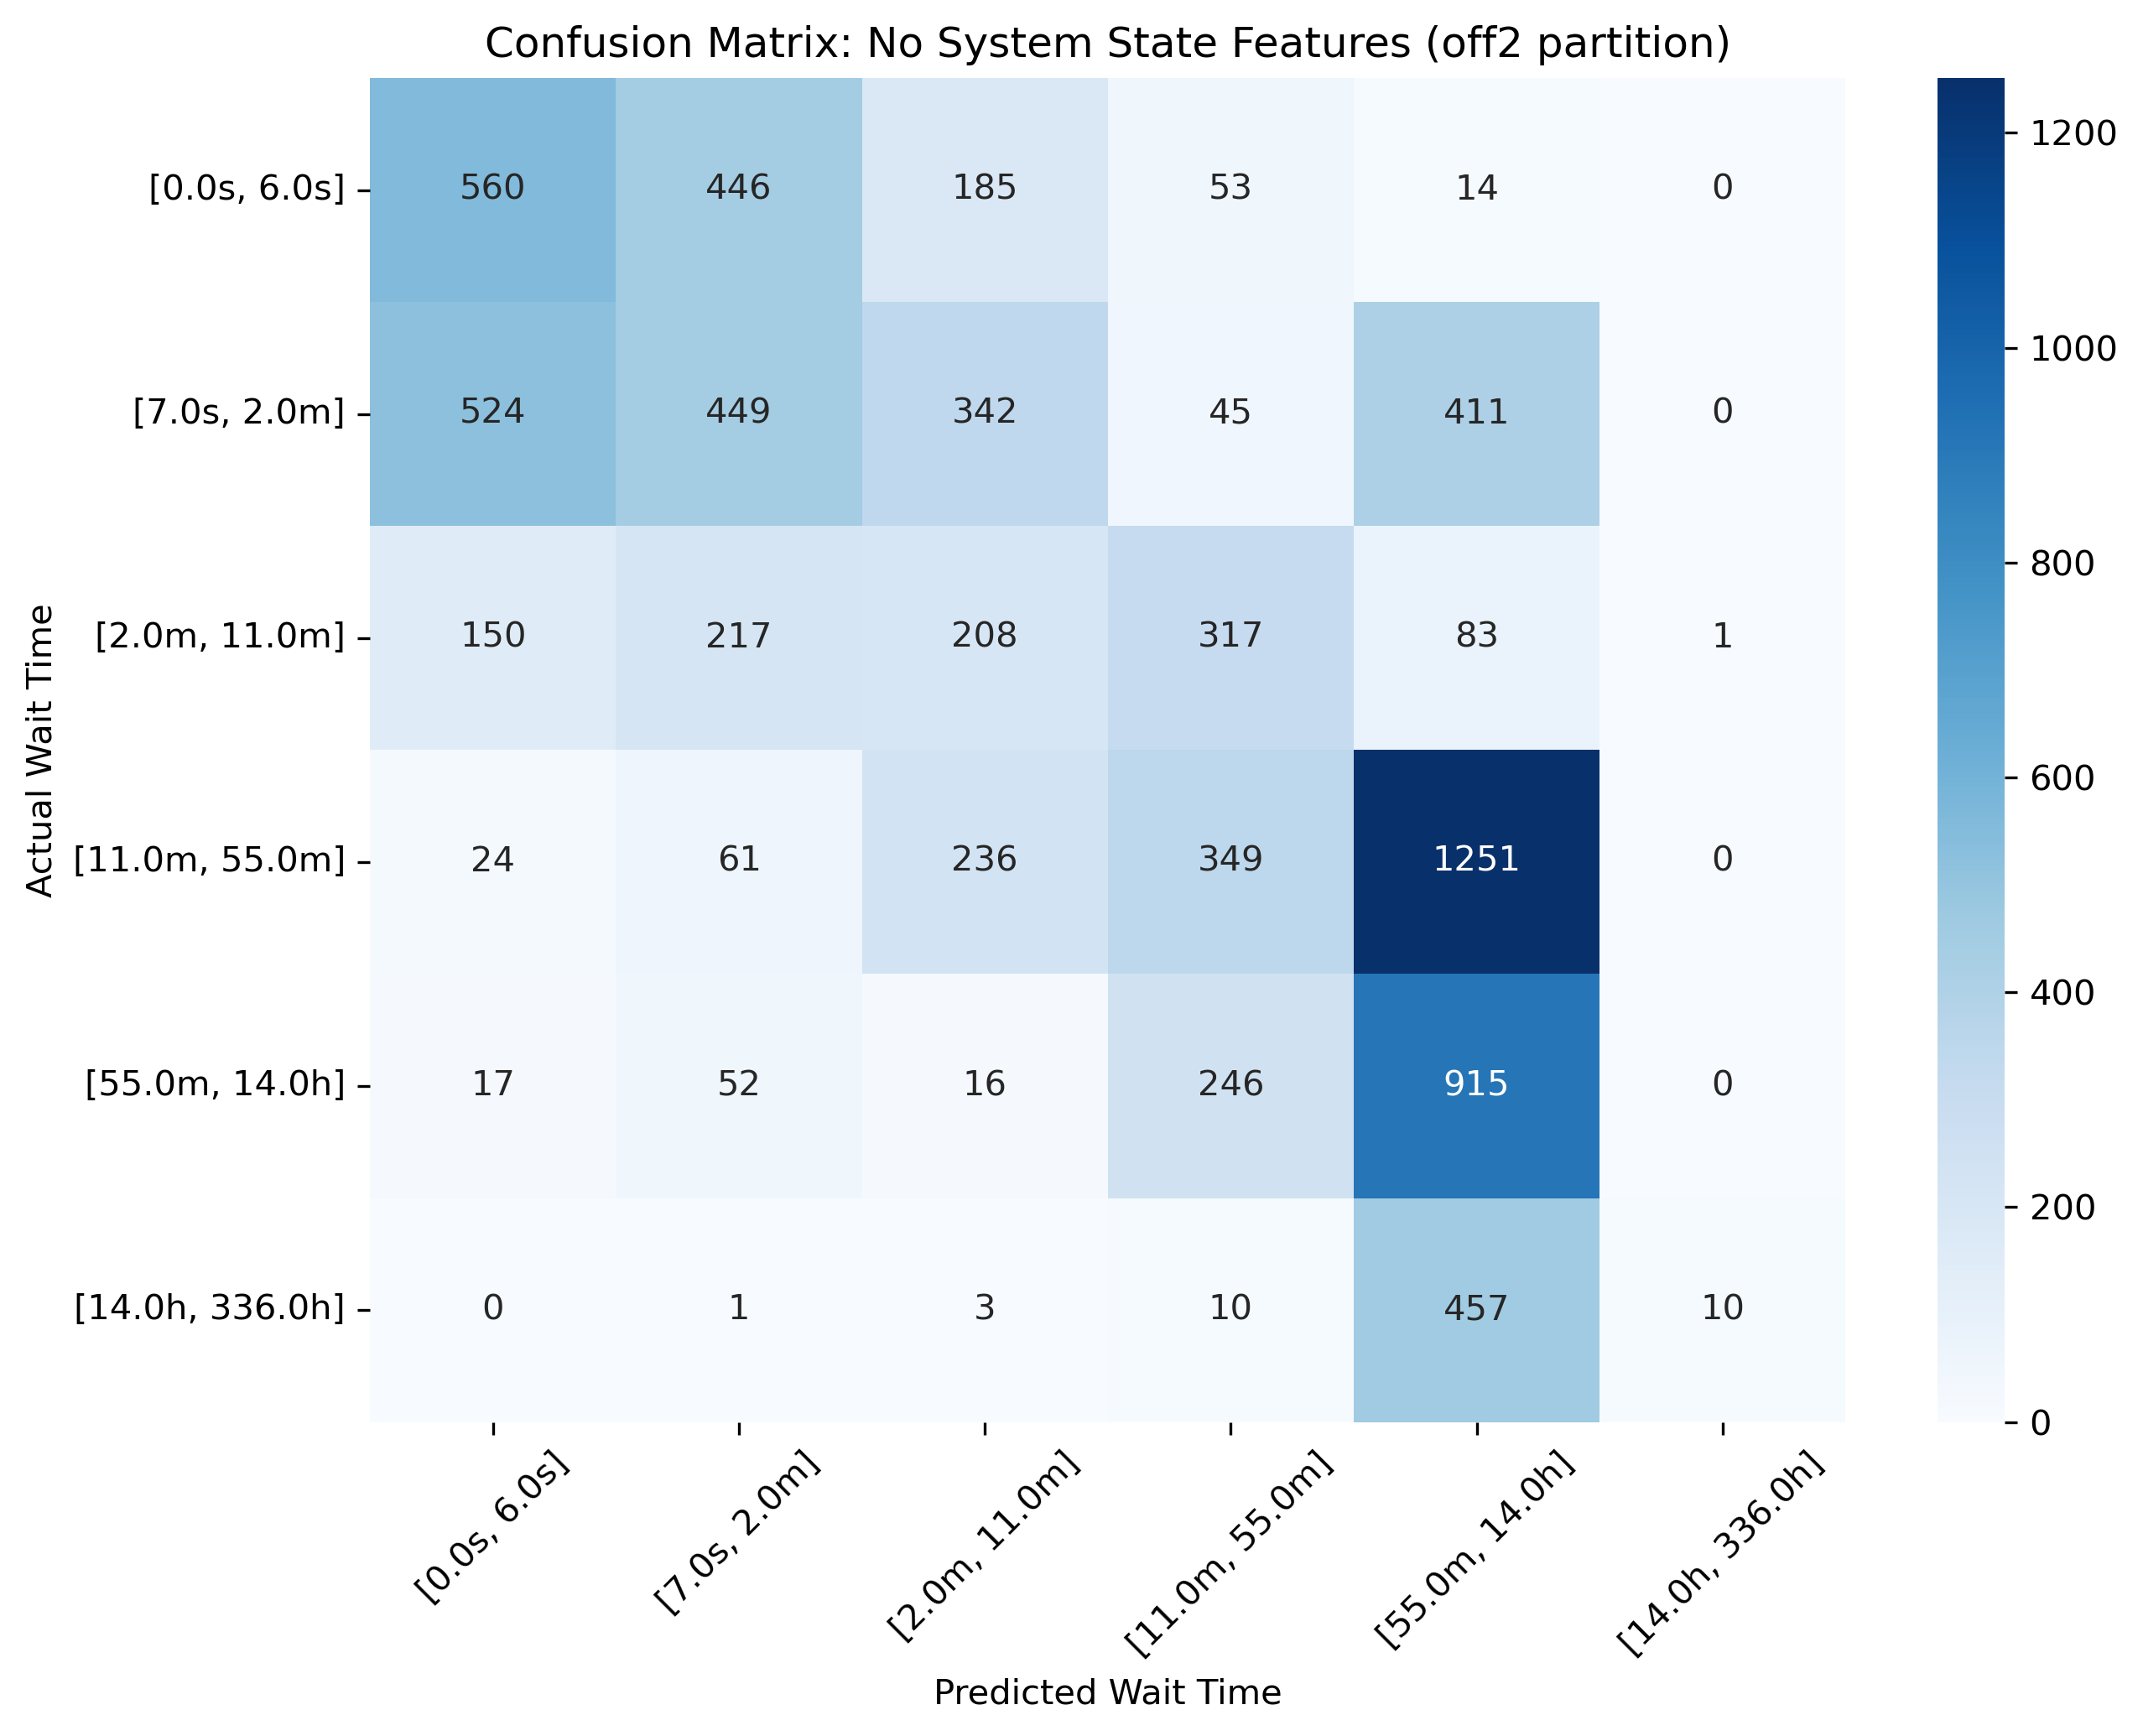

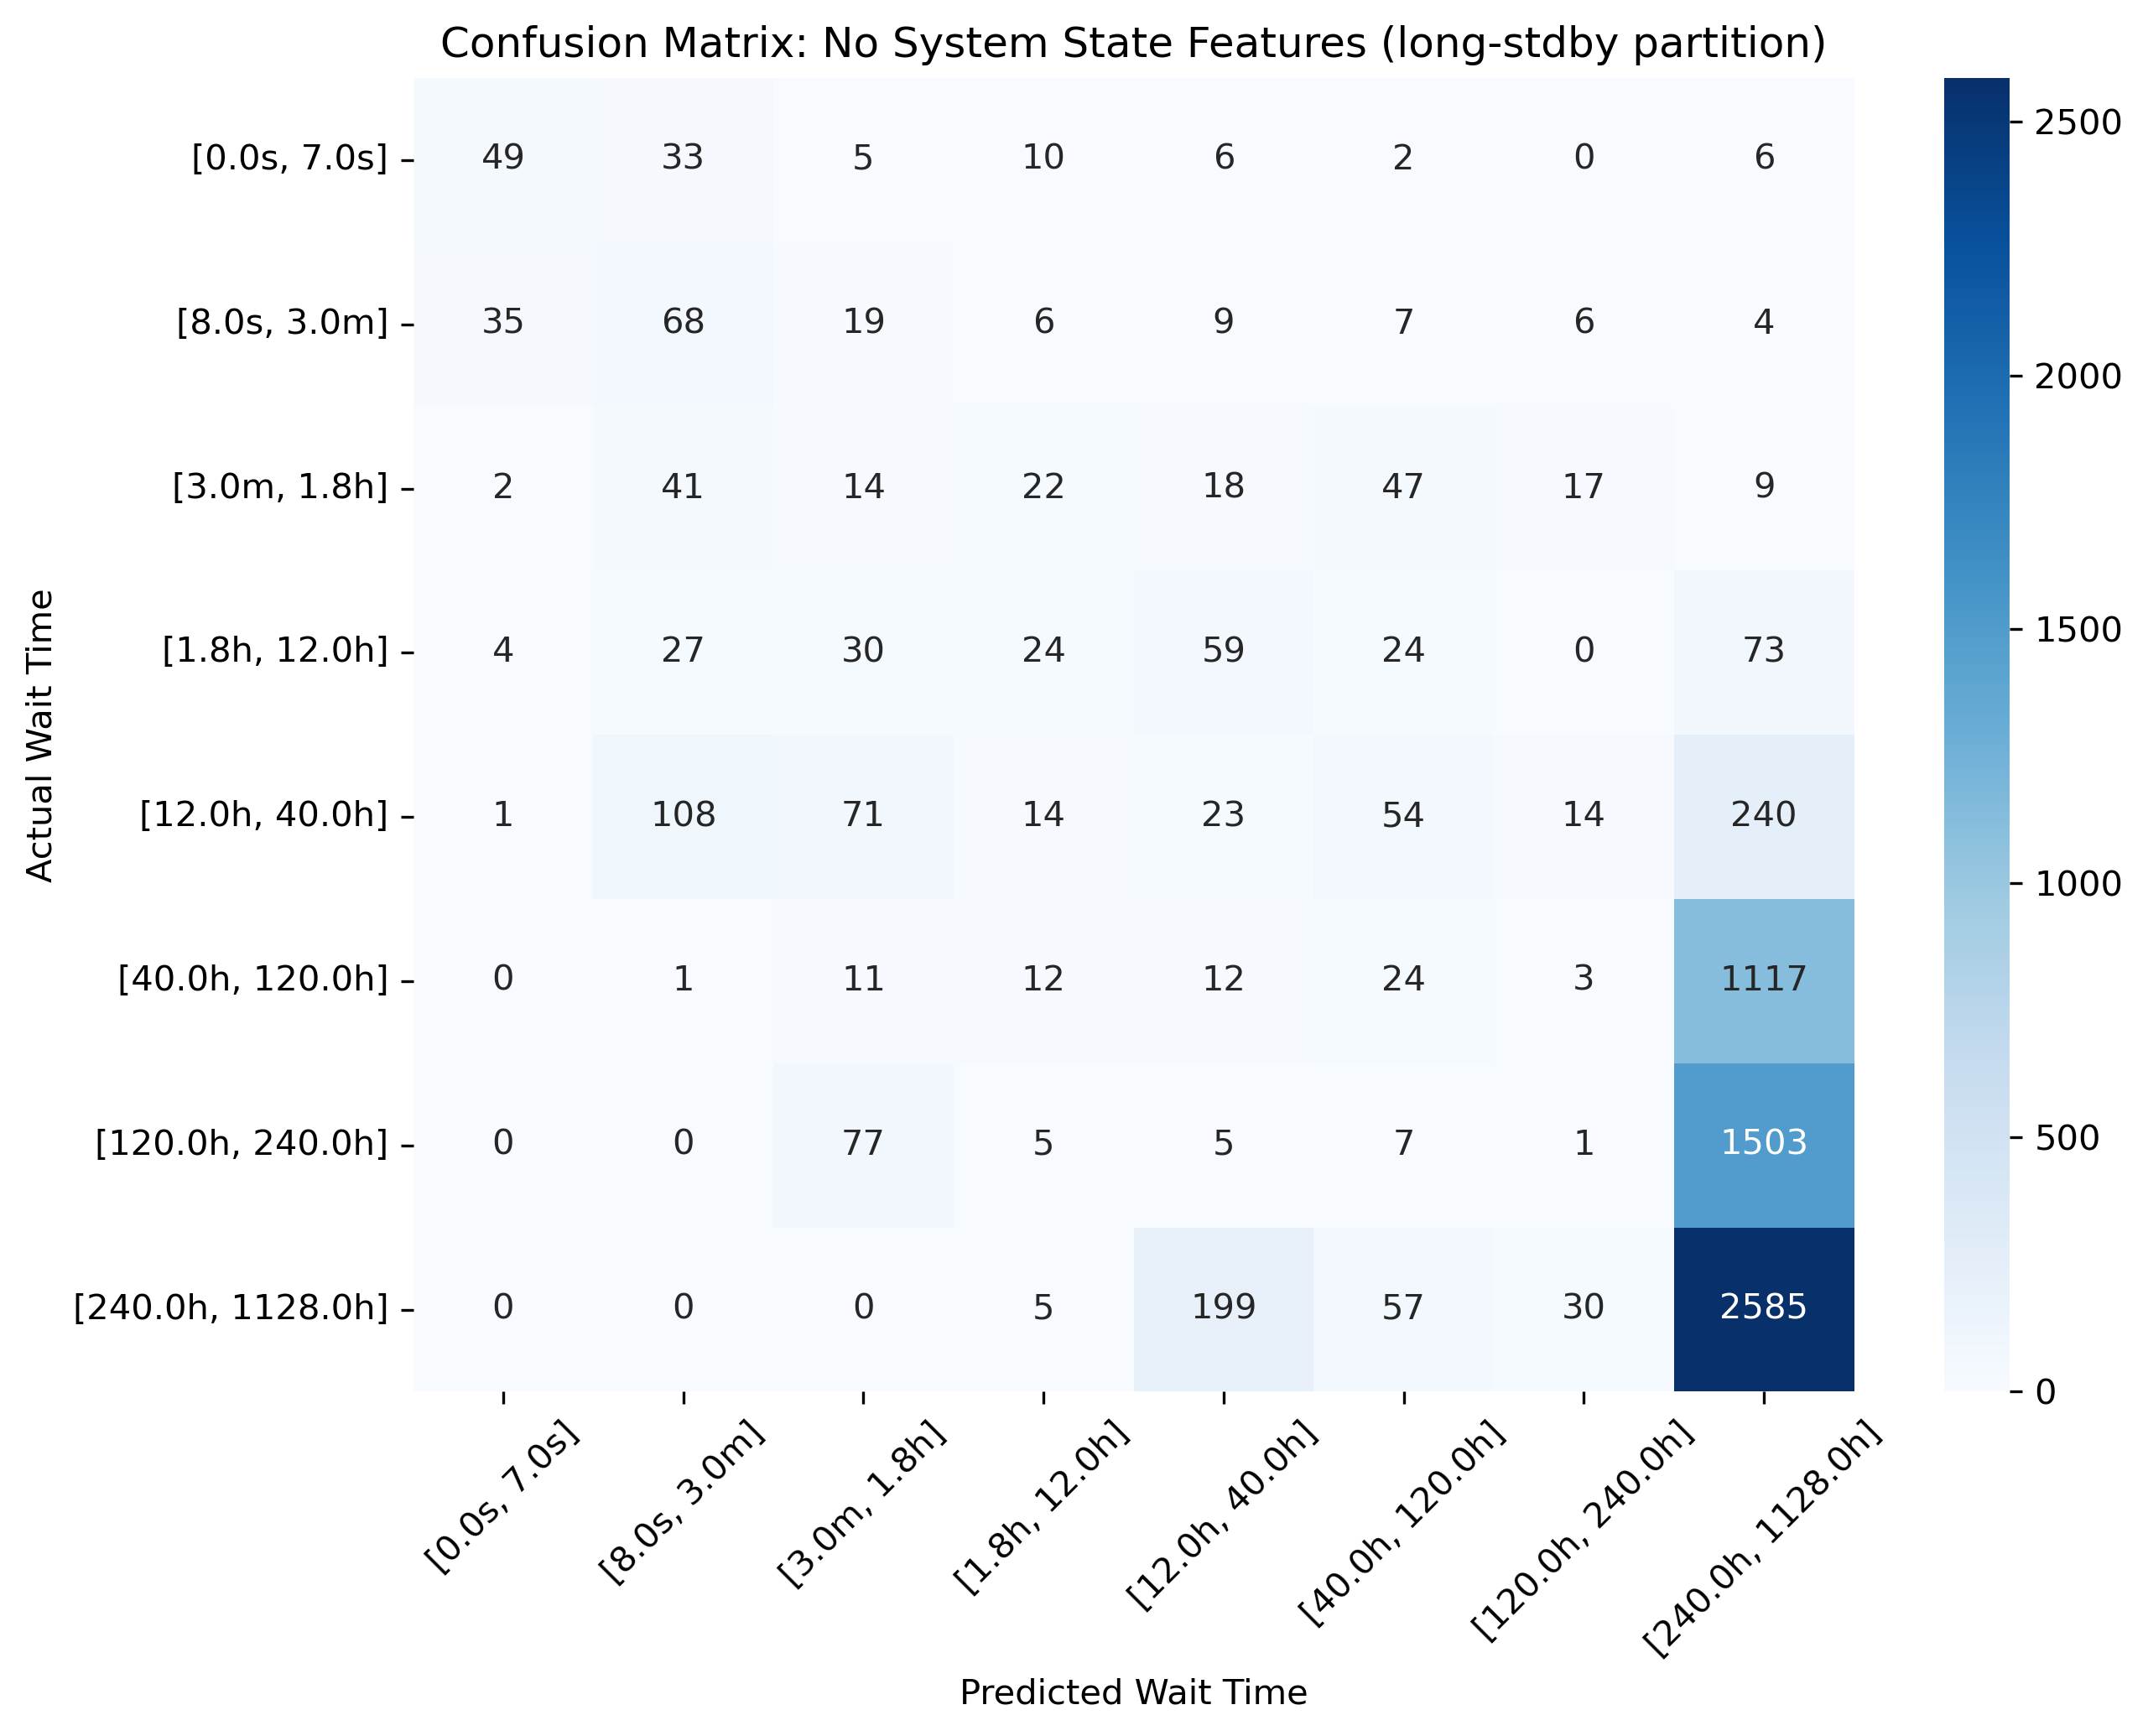

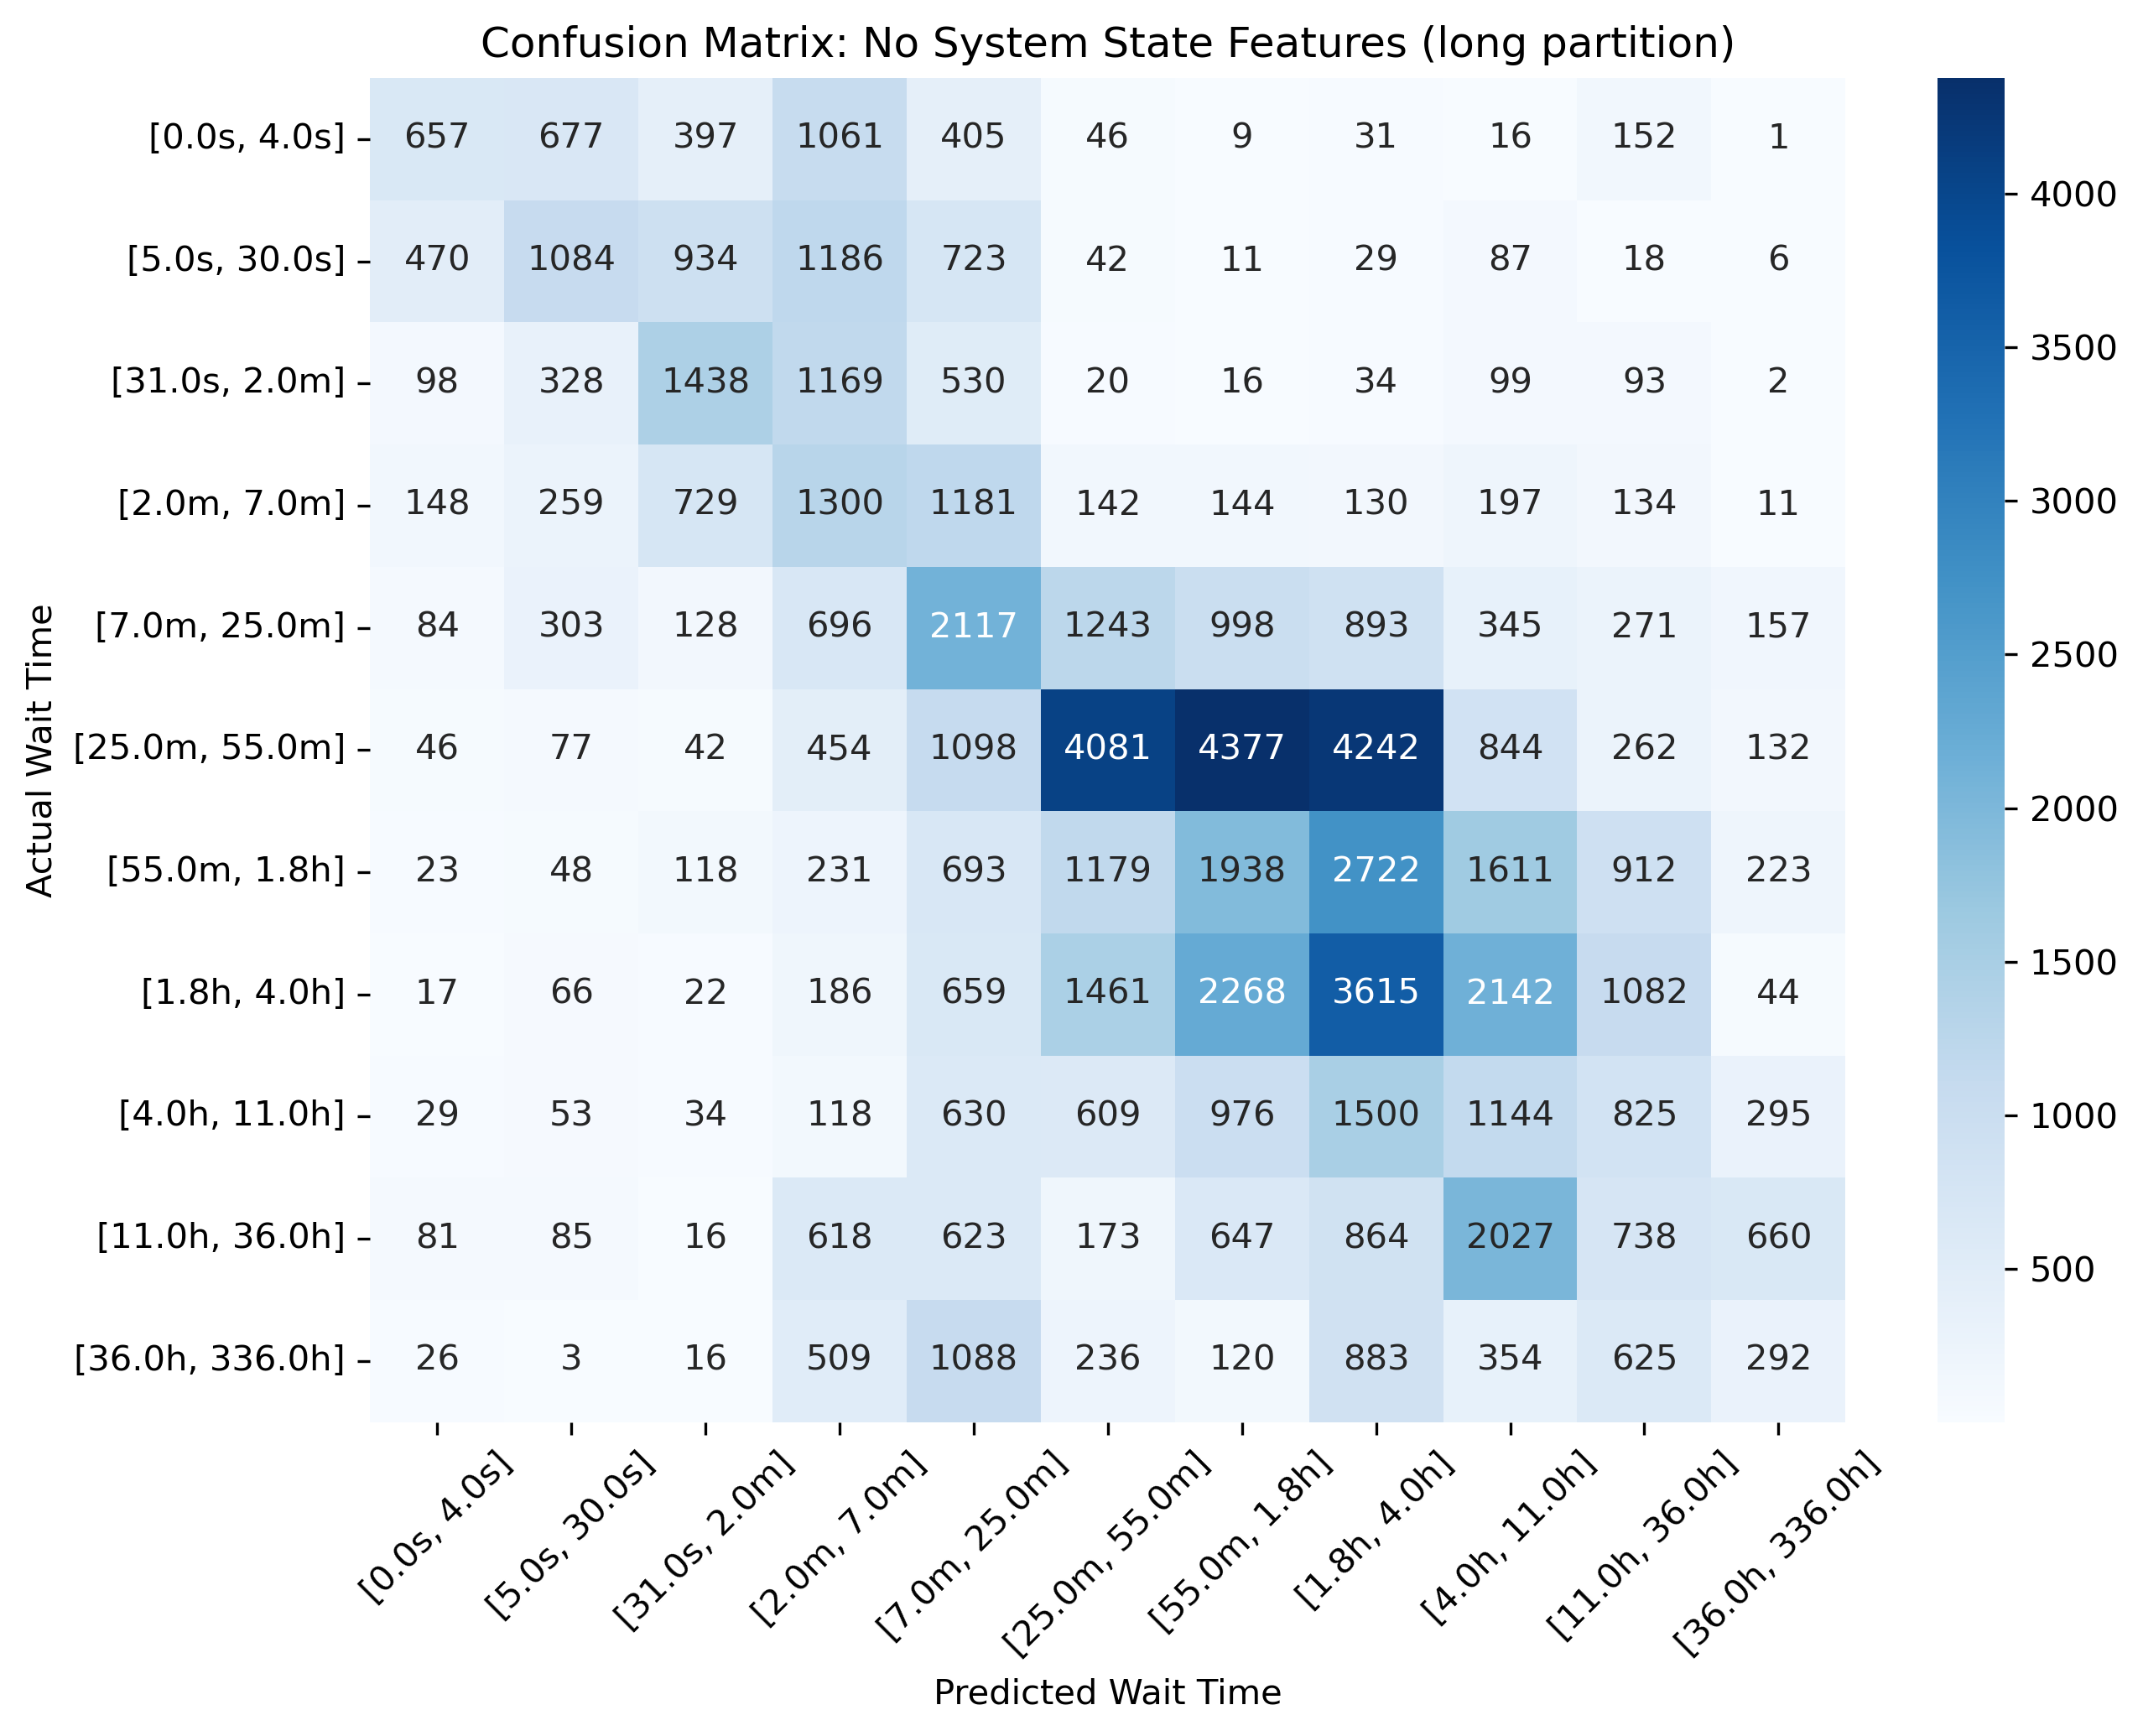

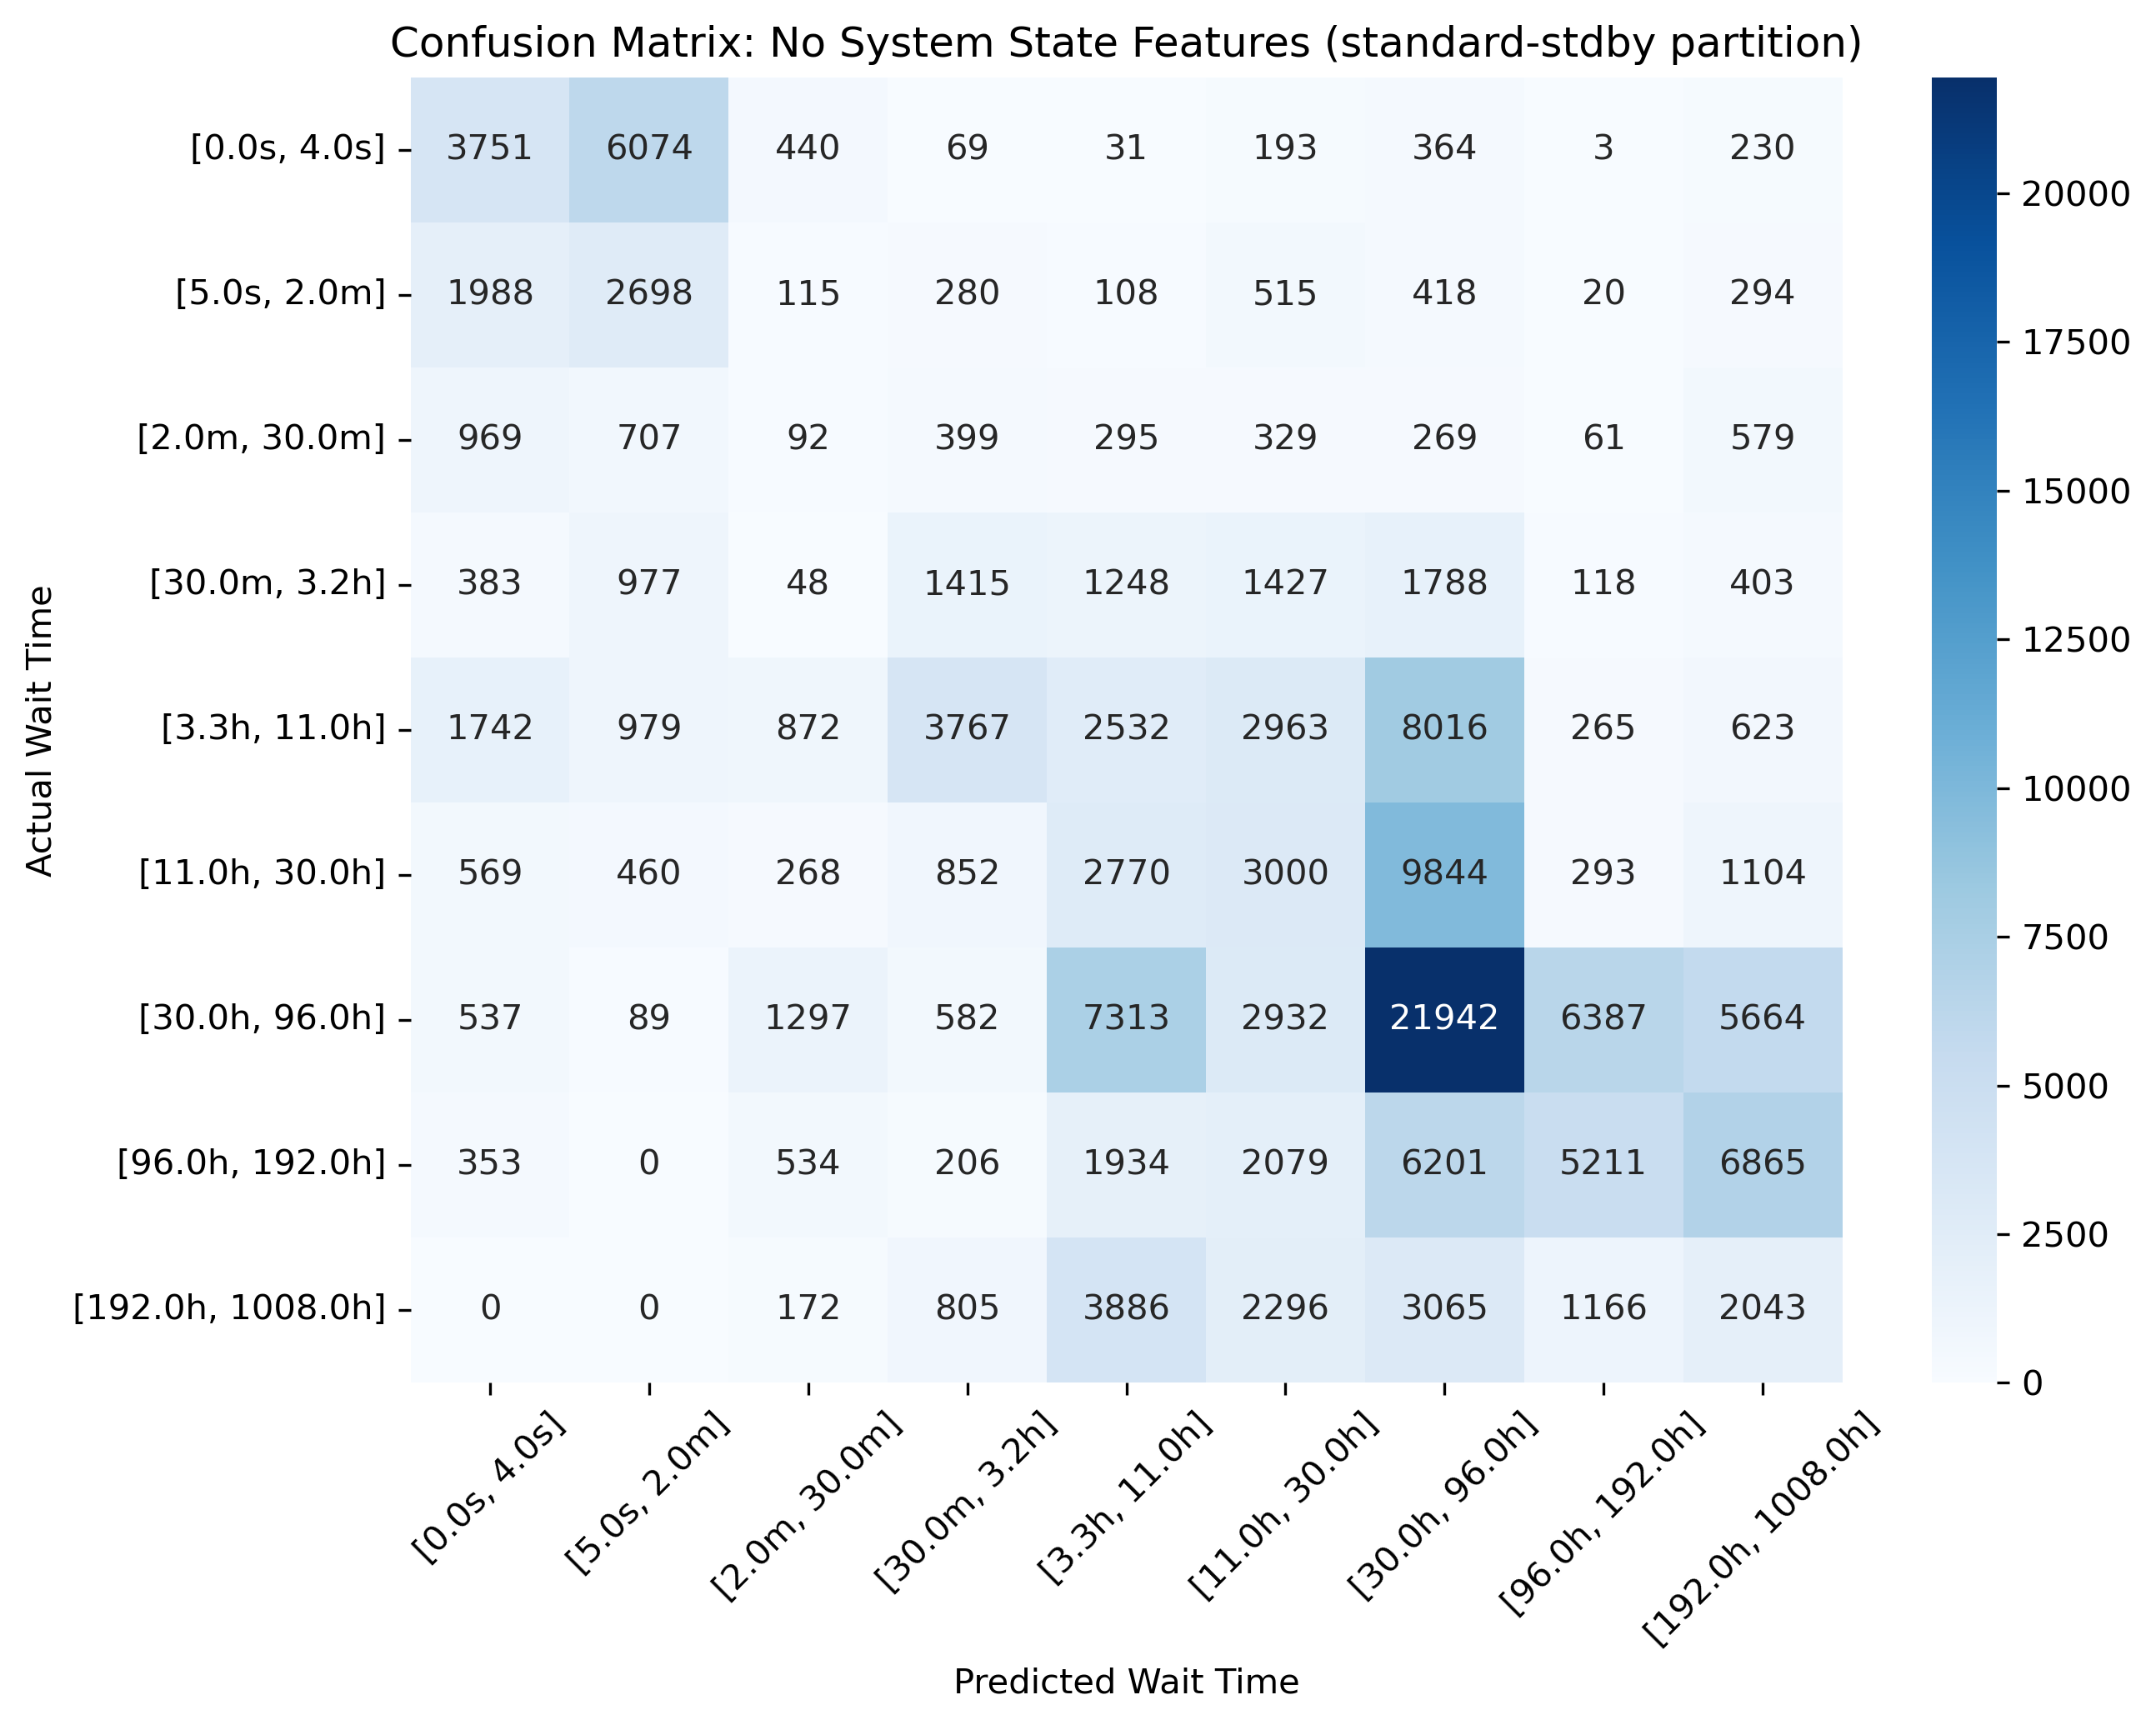

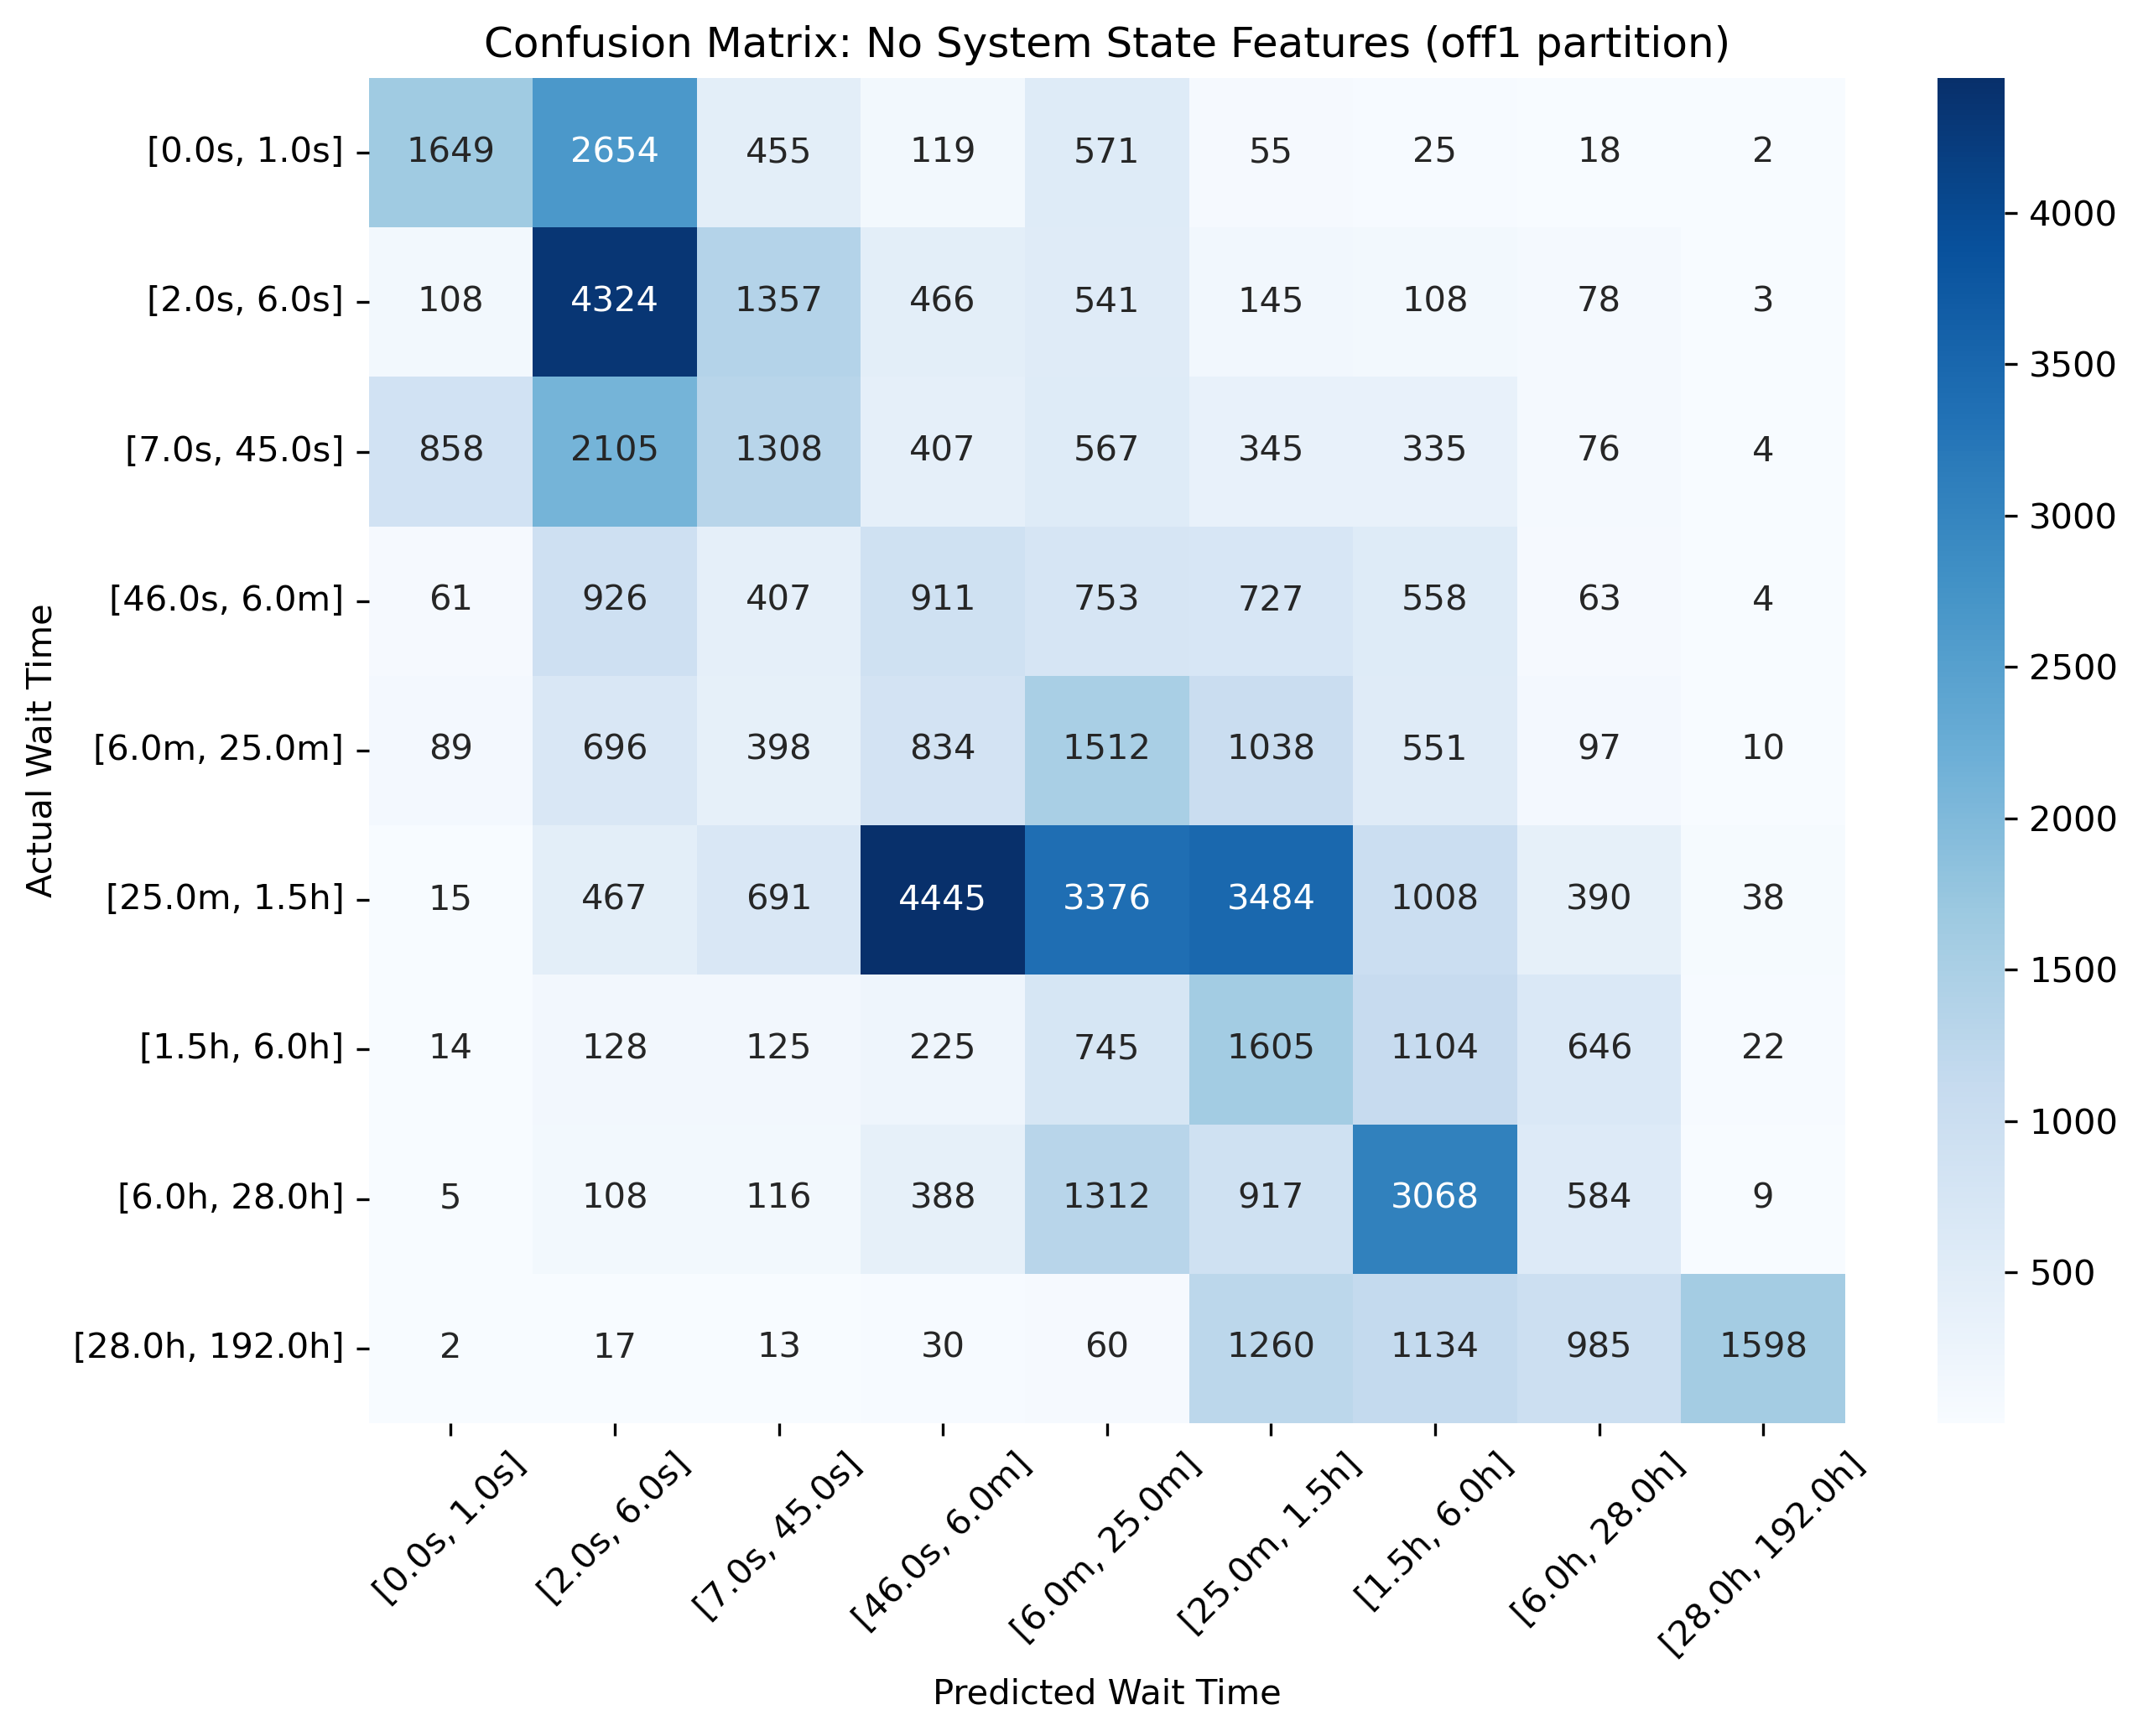

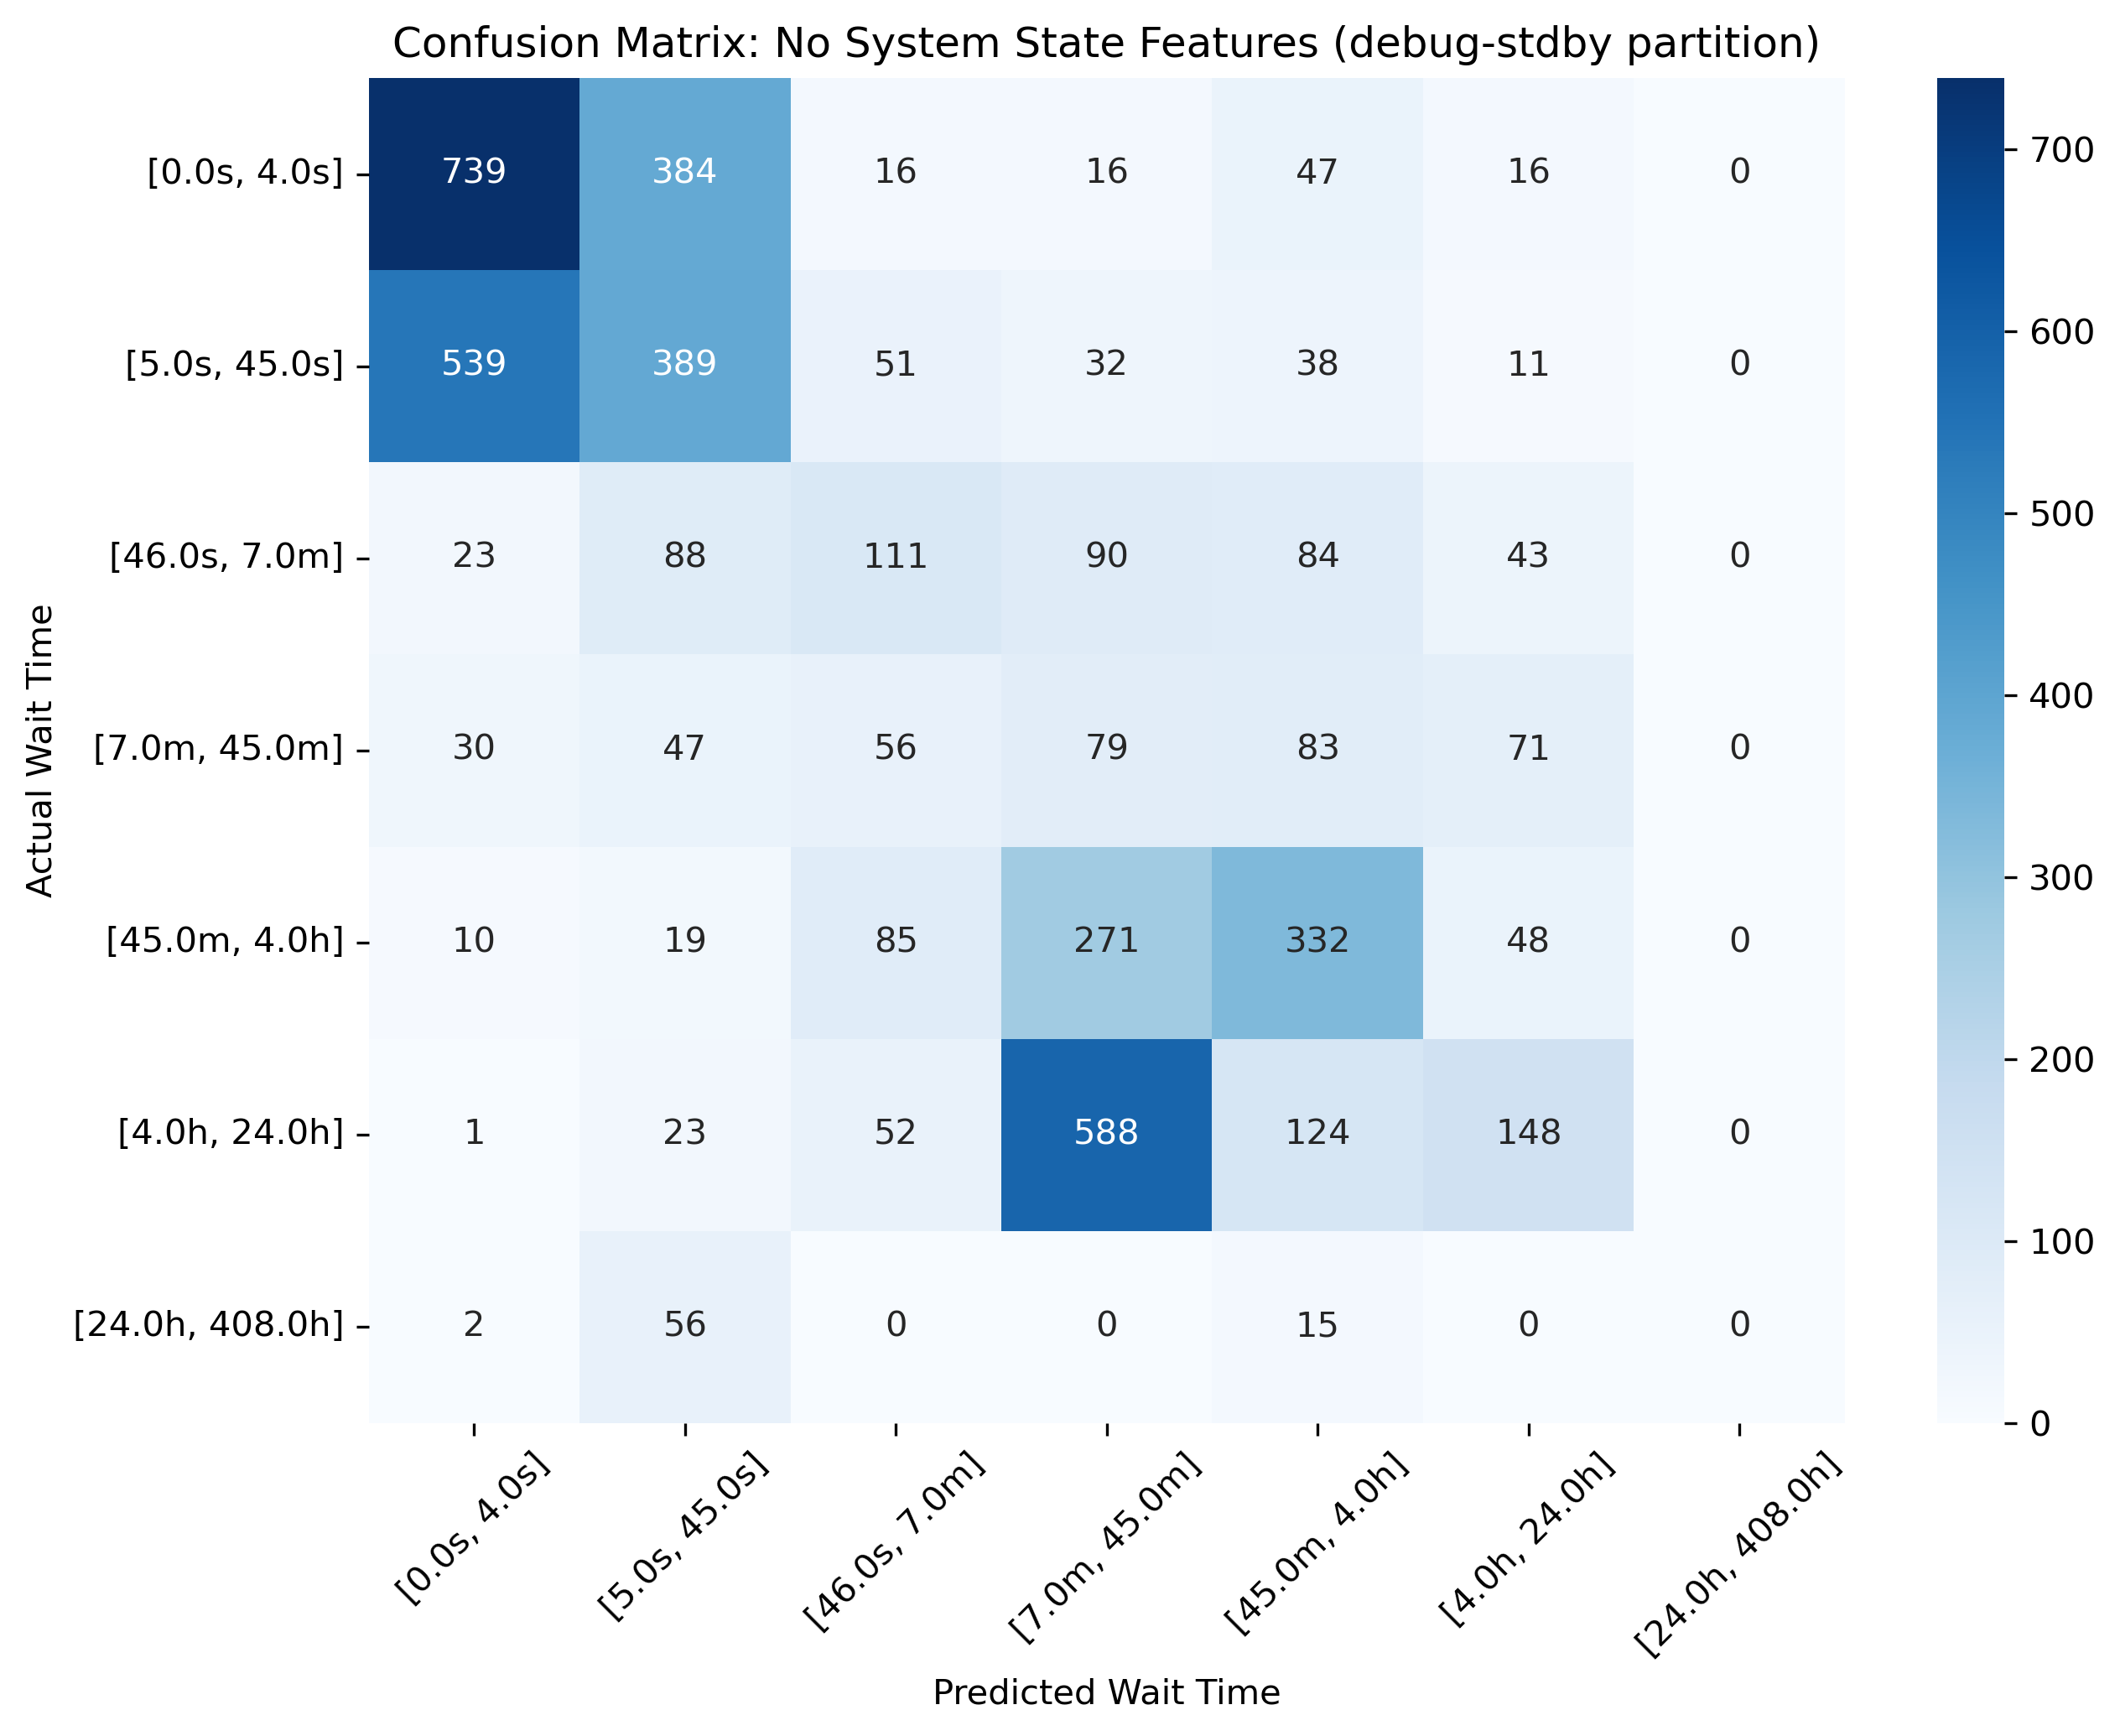

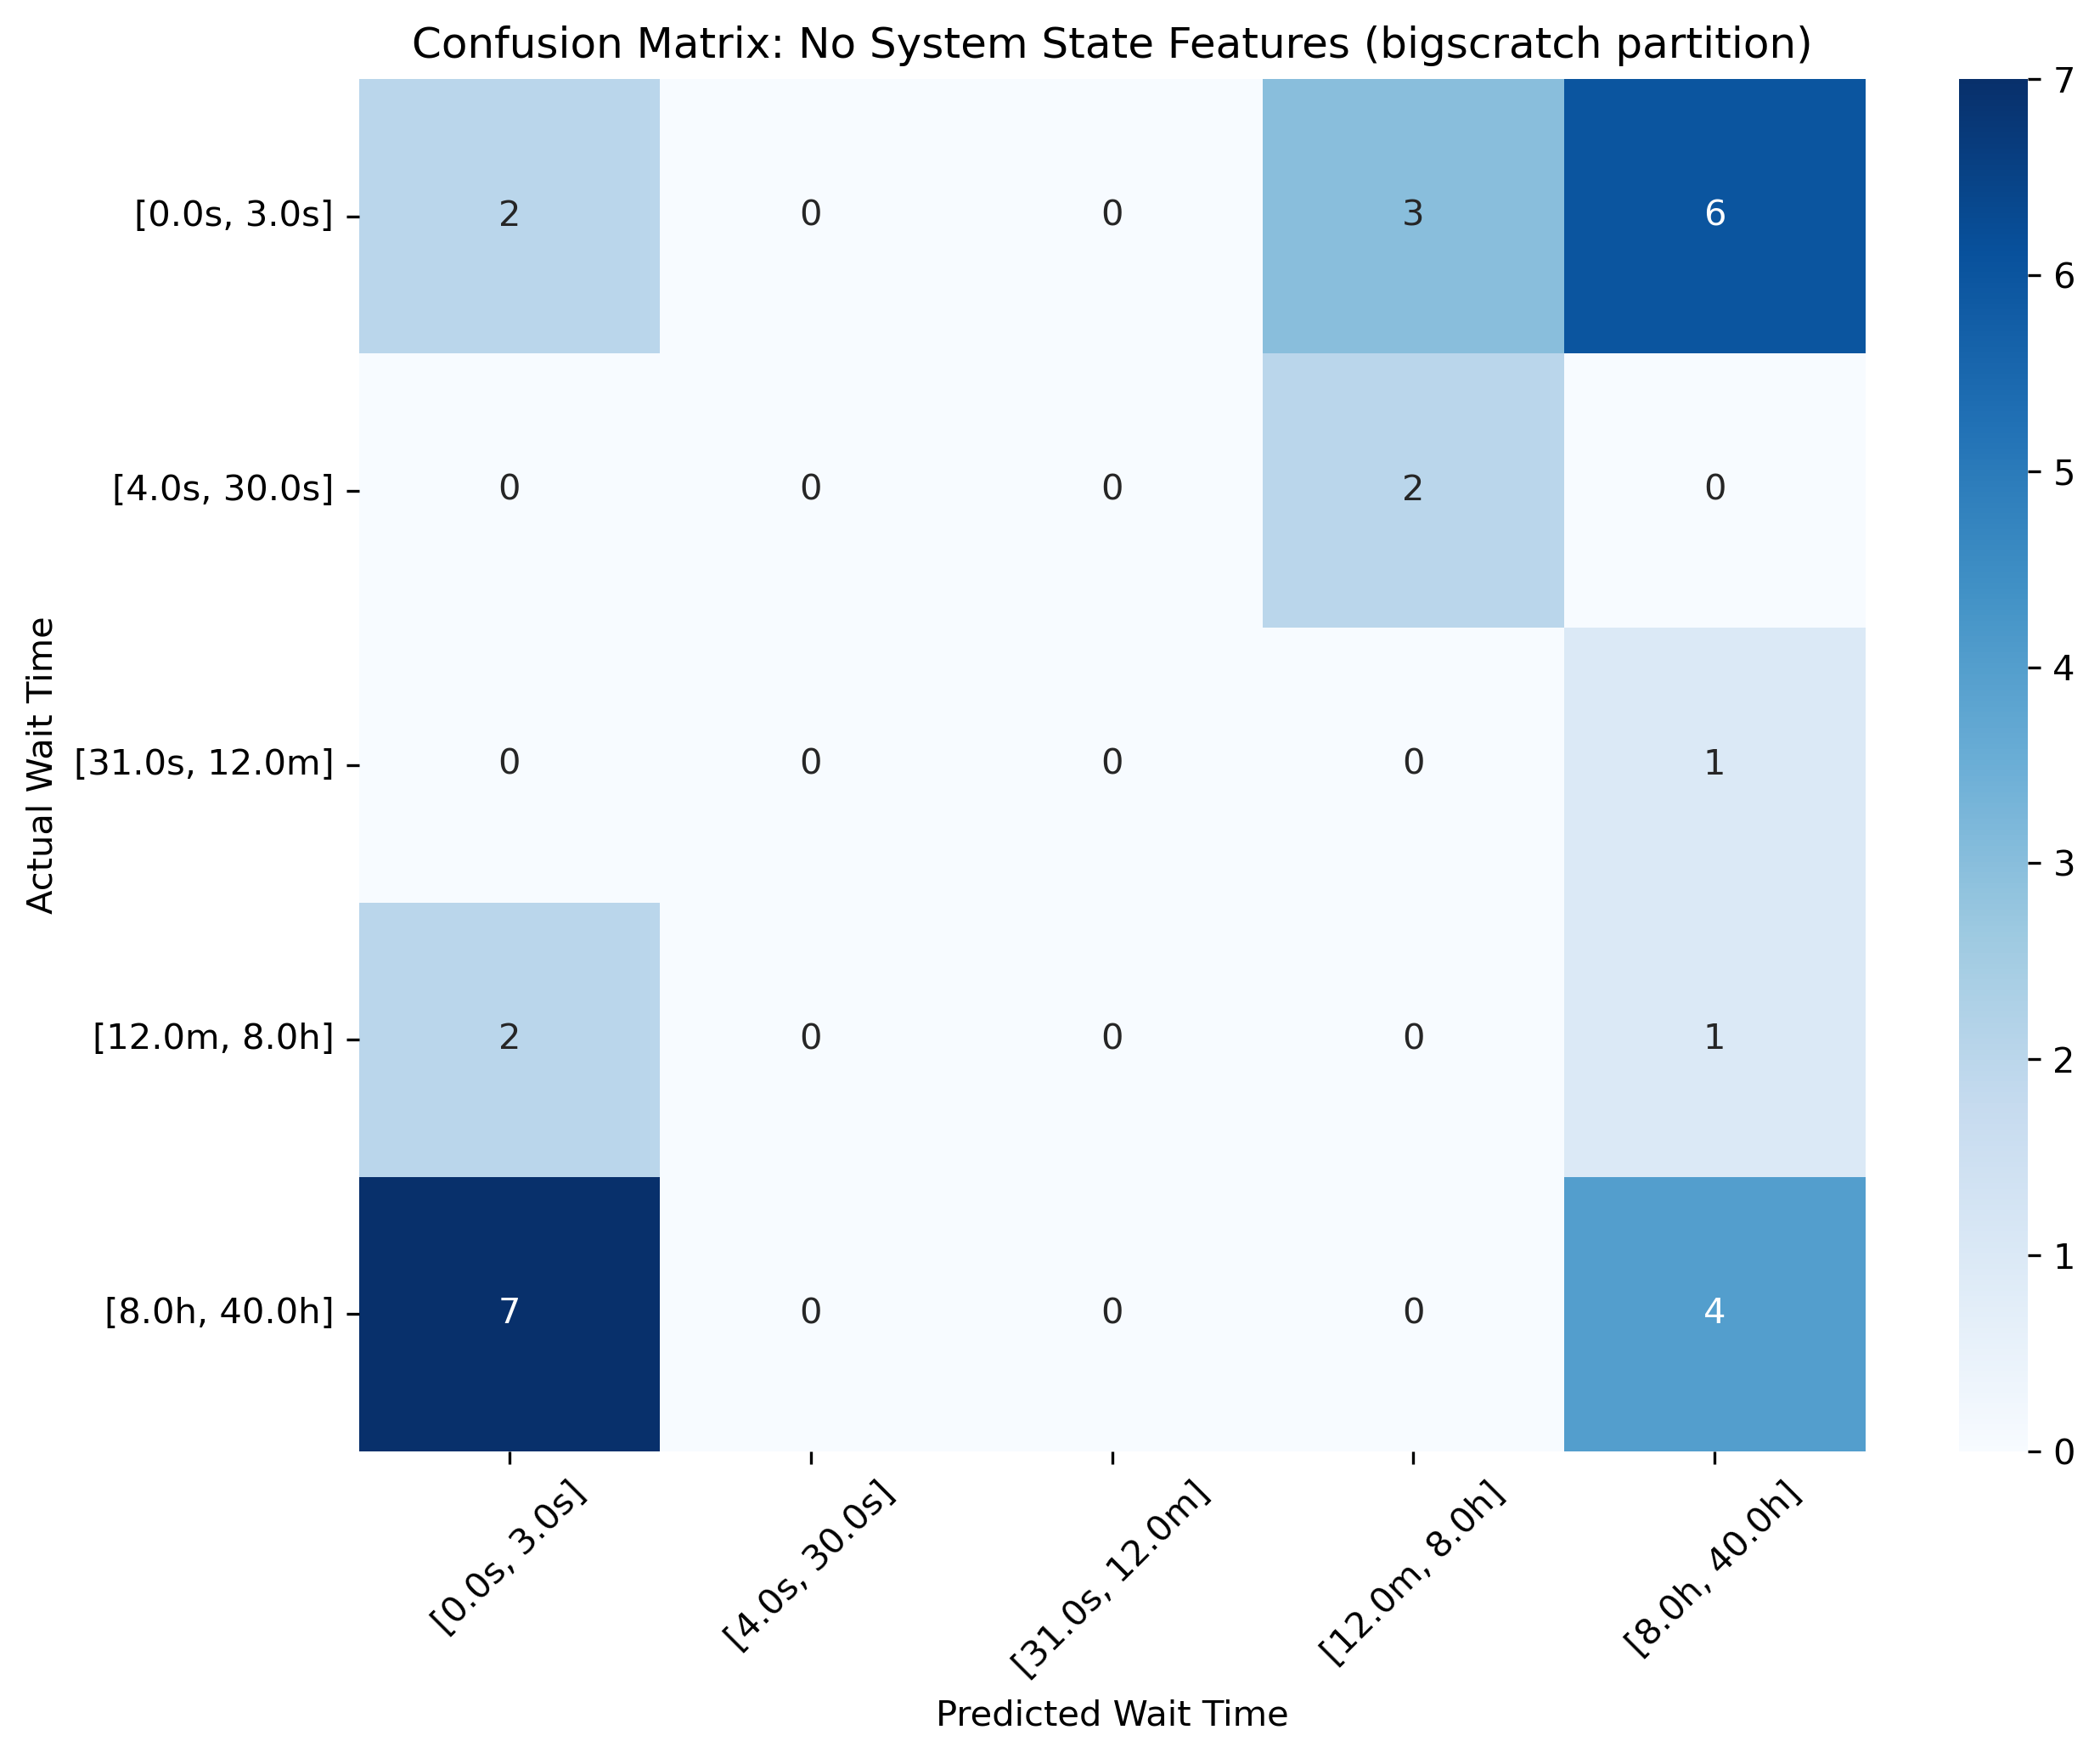

zero-size array to reduction operation fmin which has no identity
No data for off1-stdby partition.


<Figure size 2700x2100 with 0 Axes>

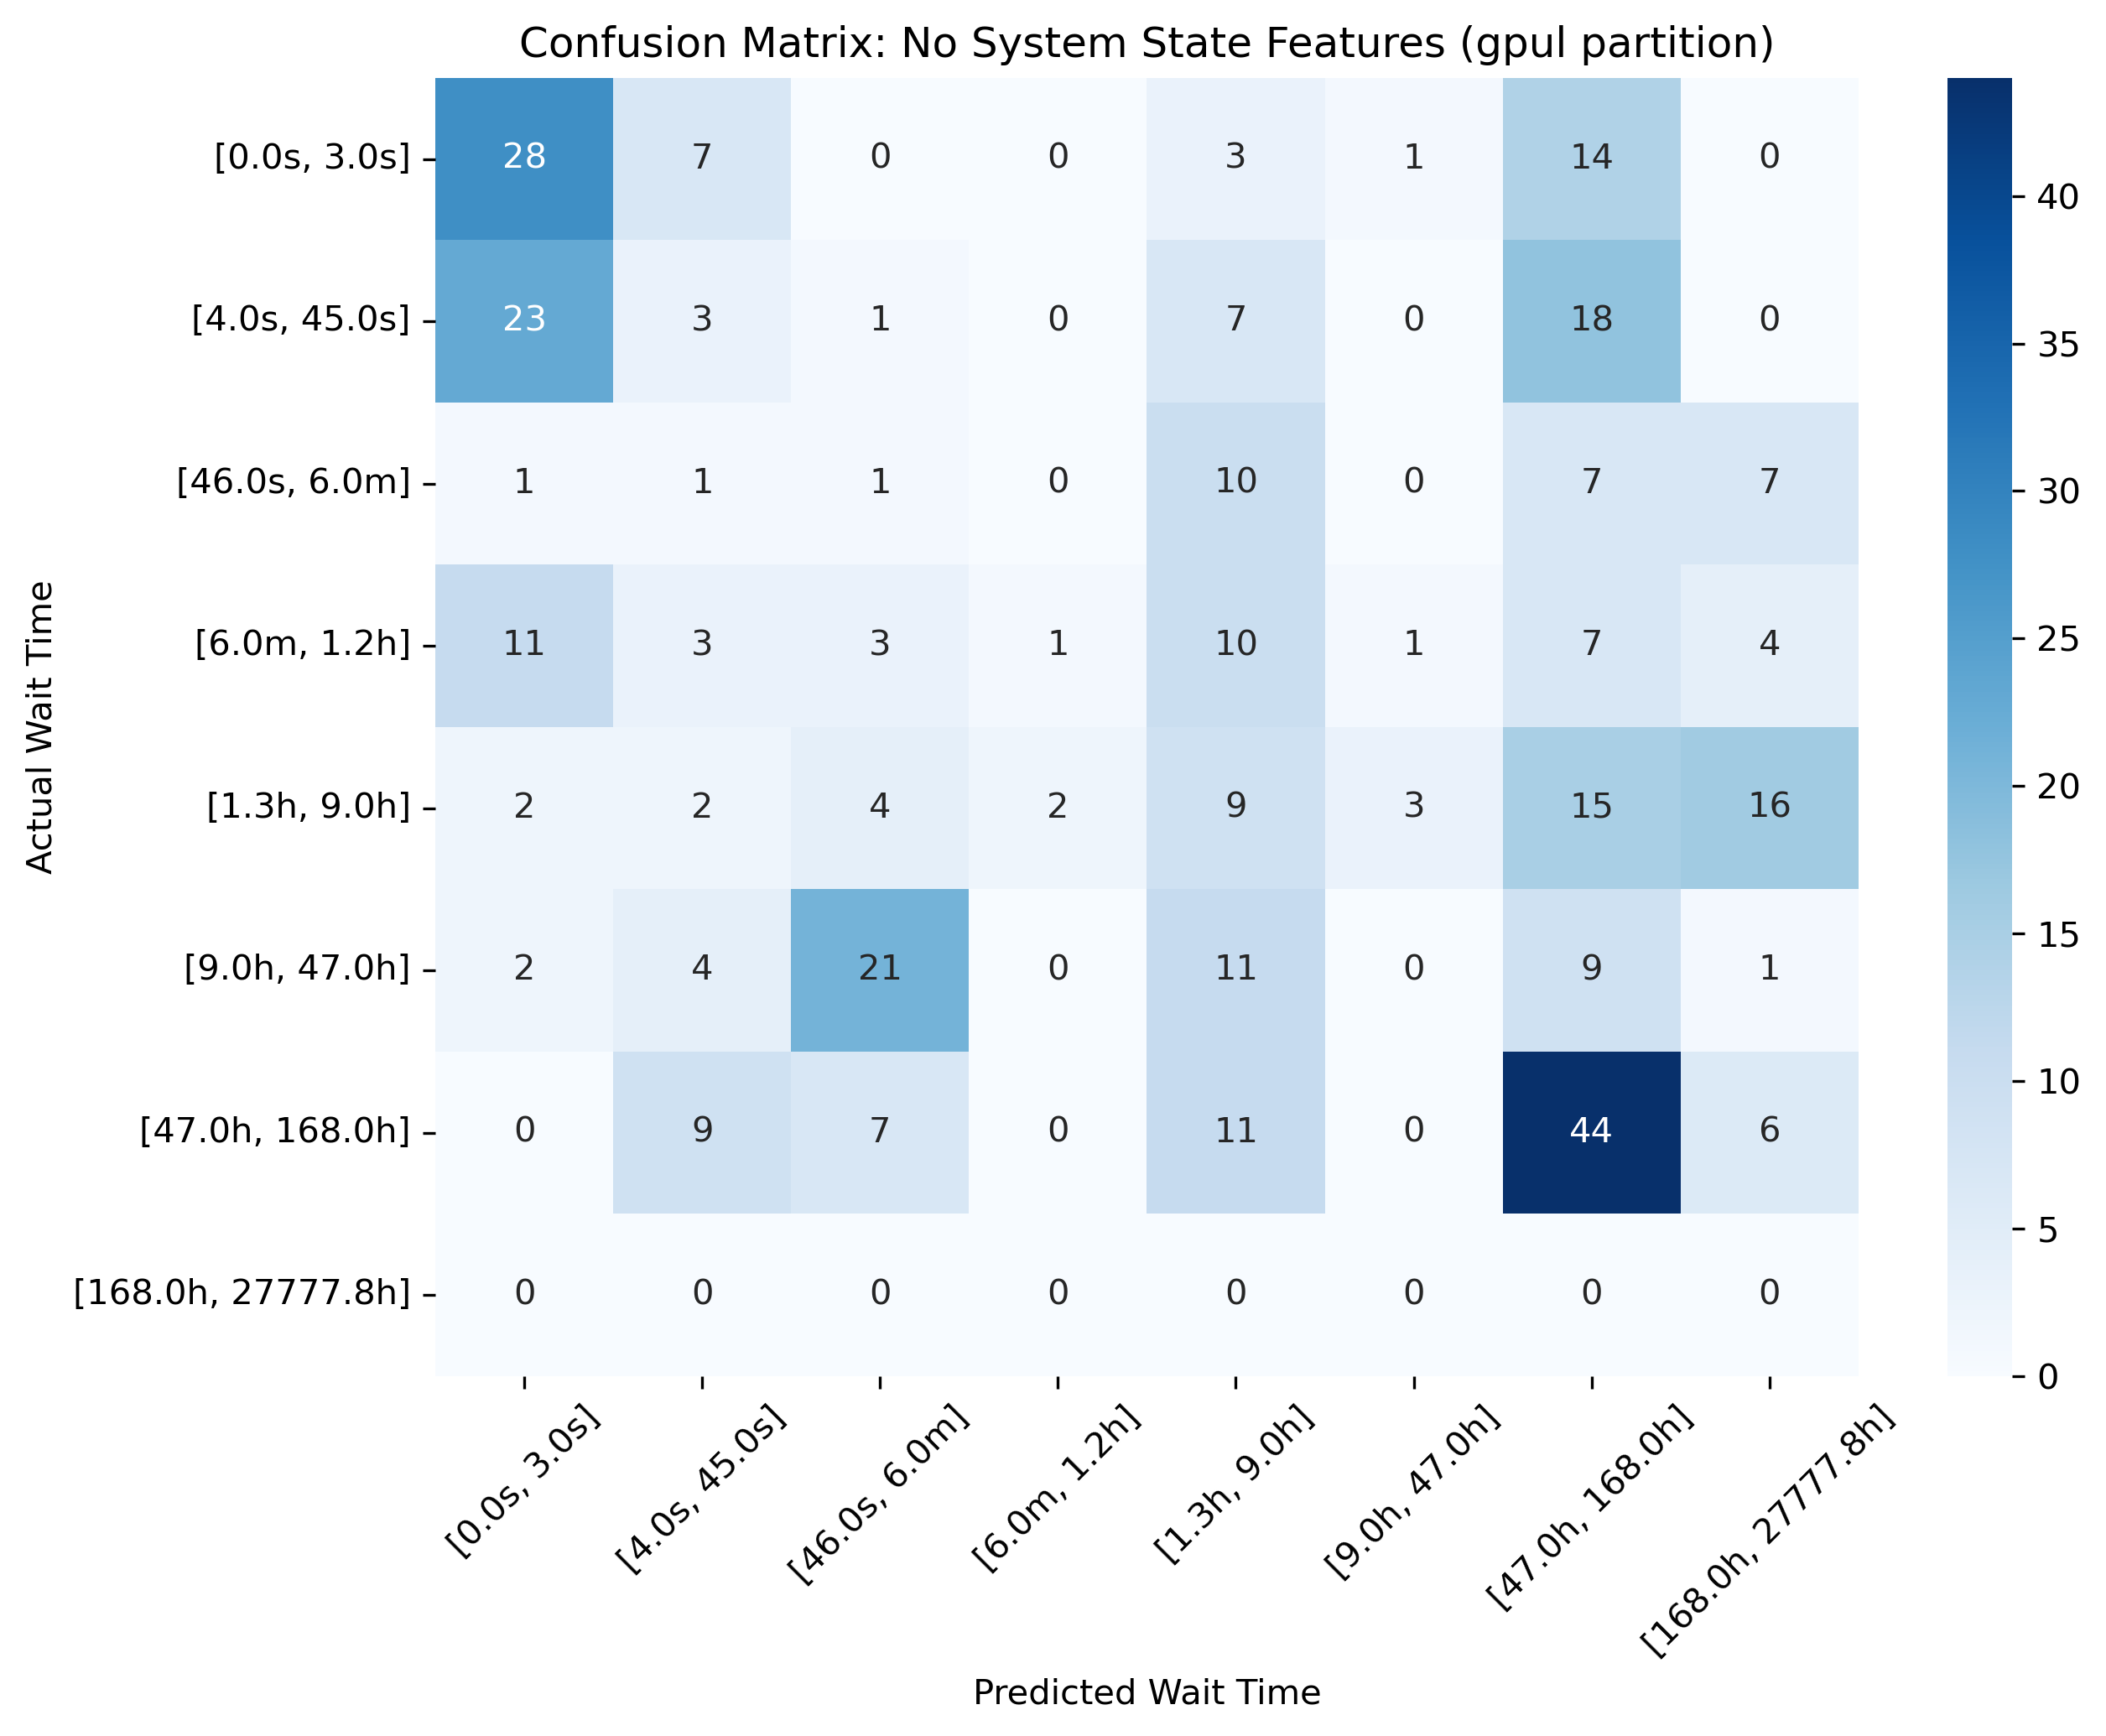

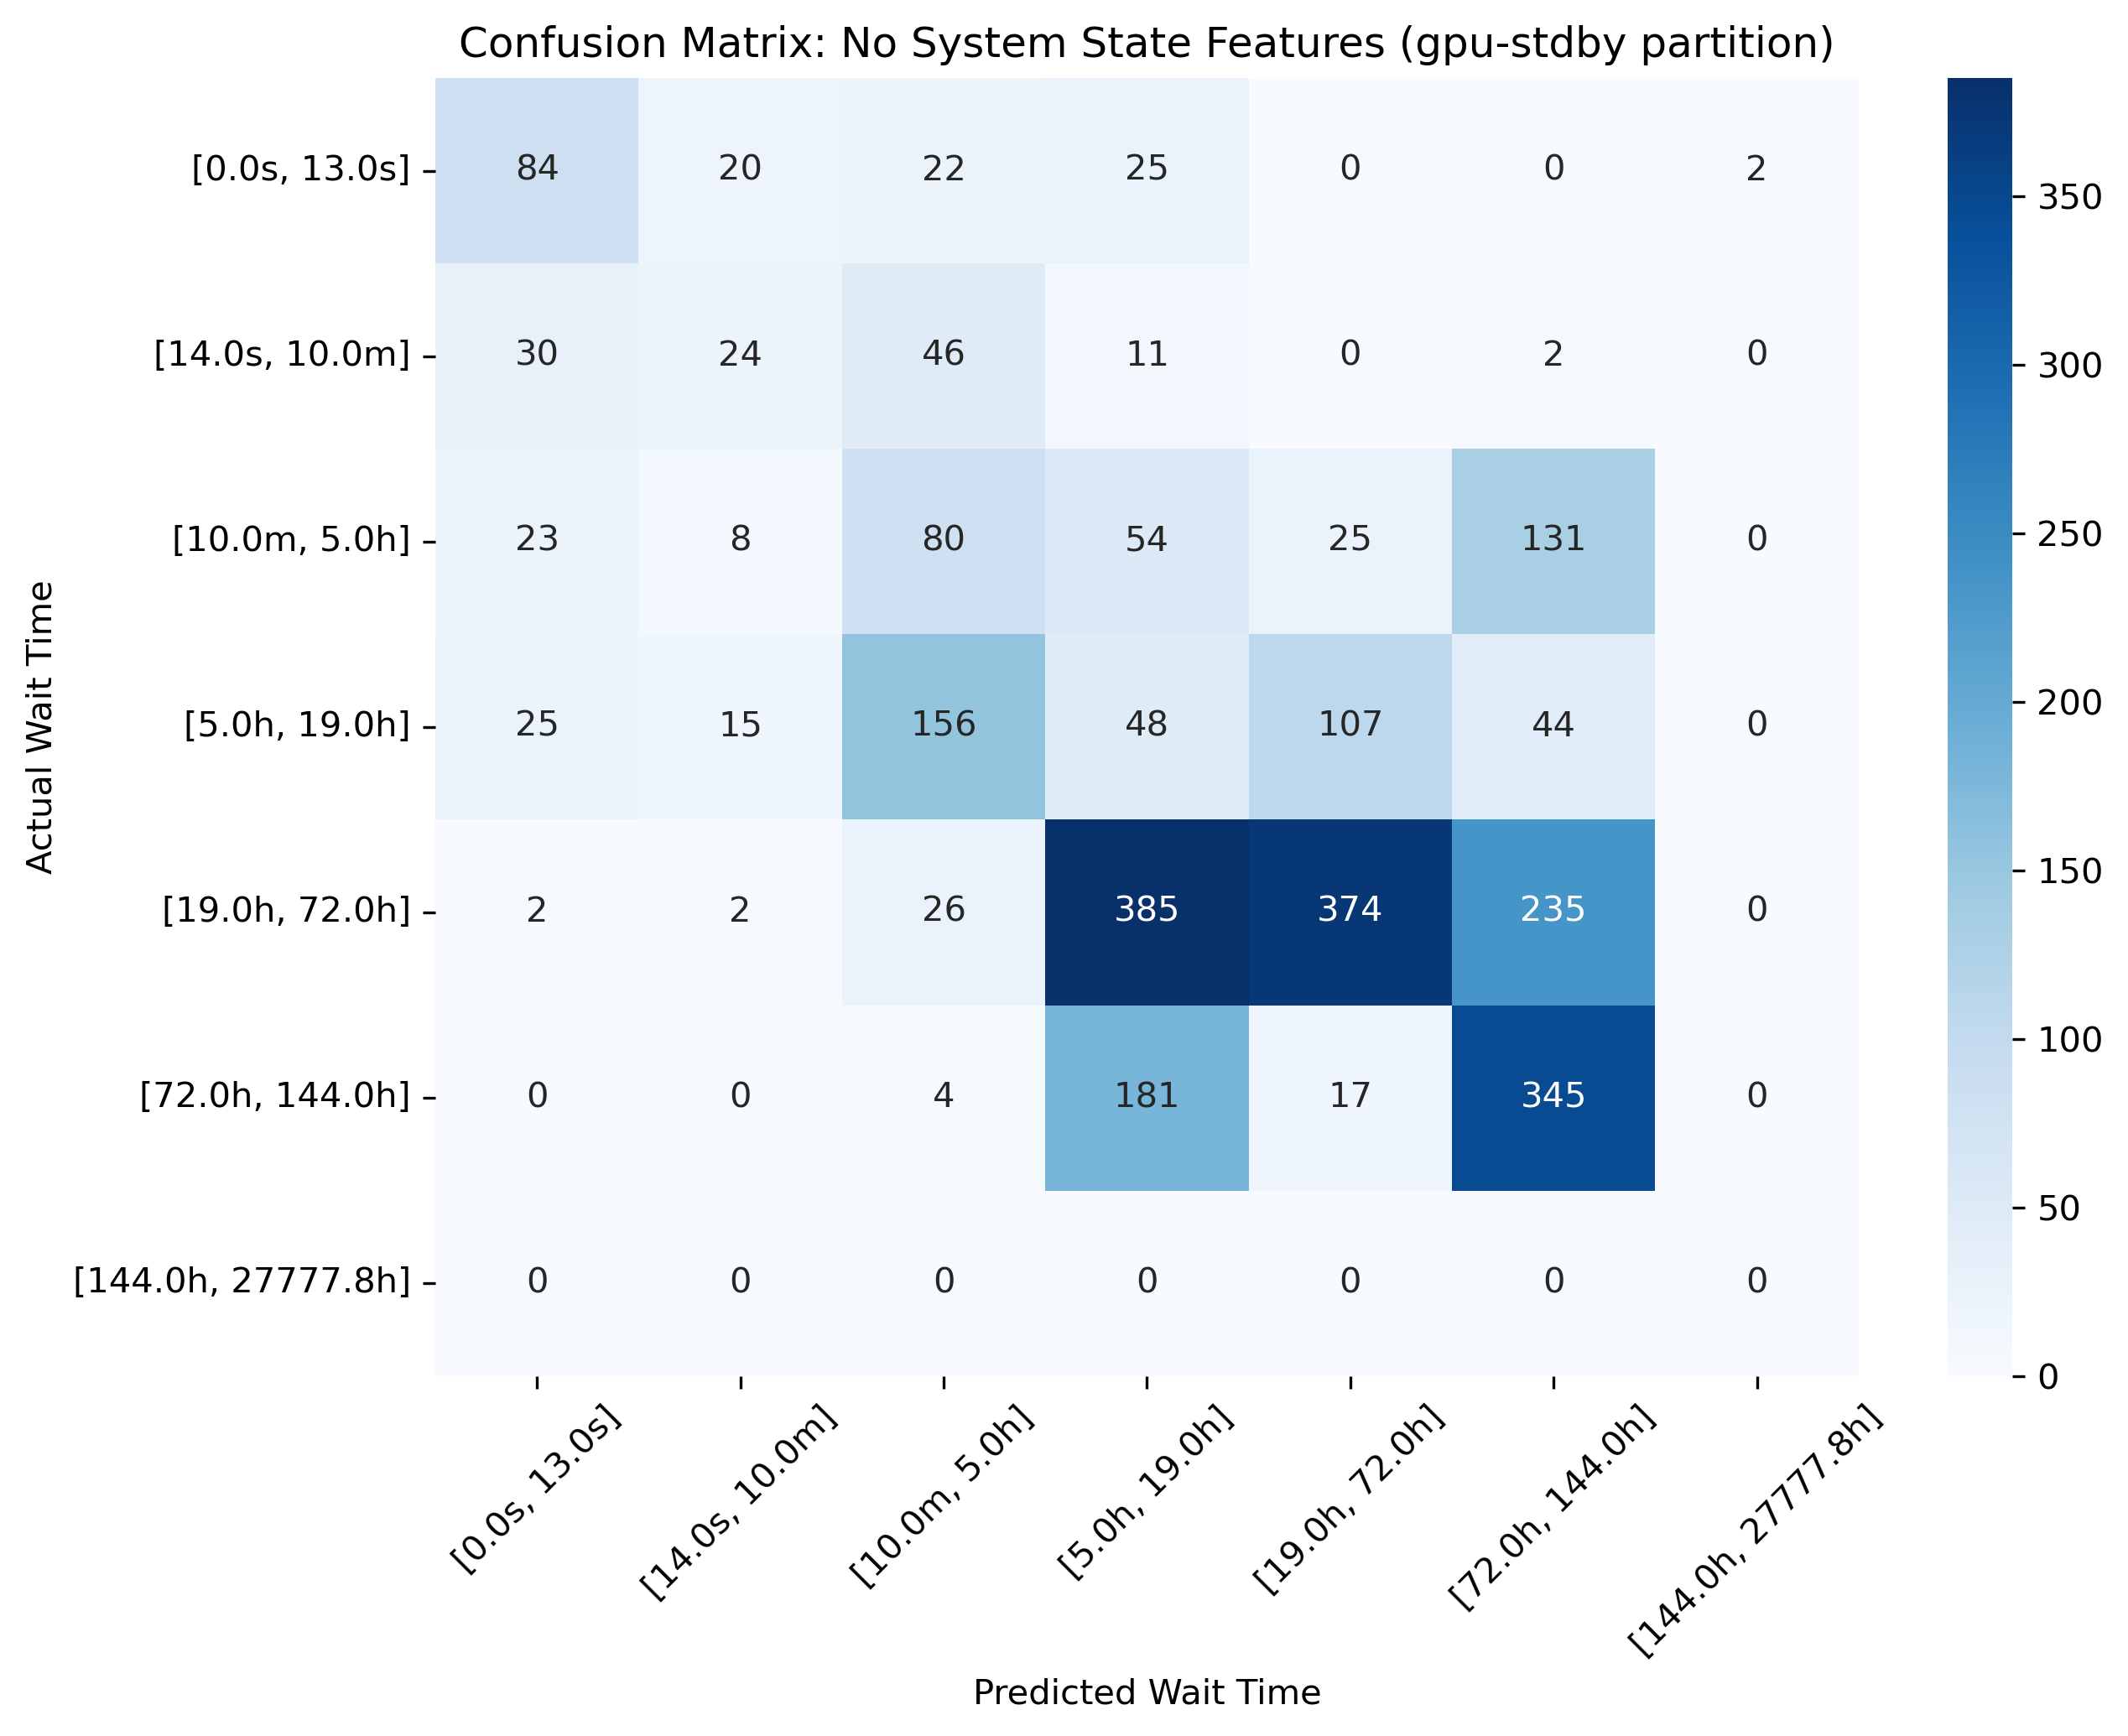

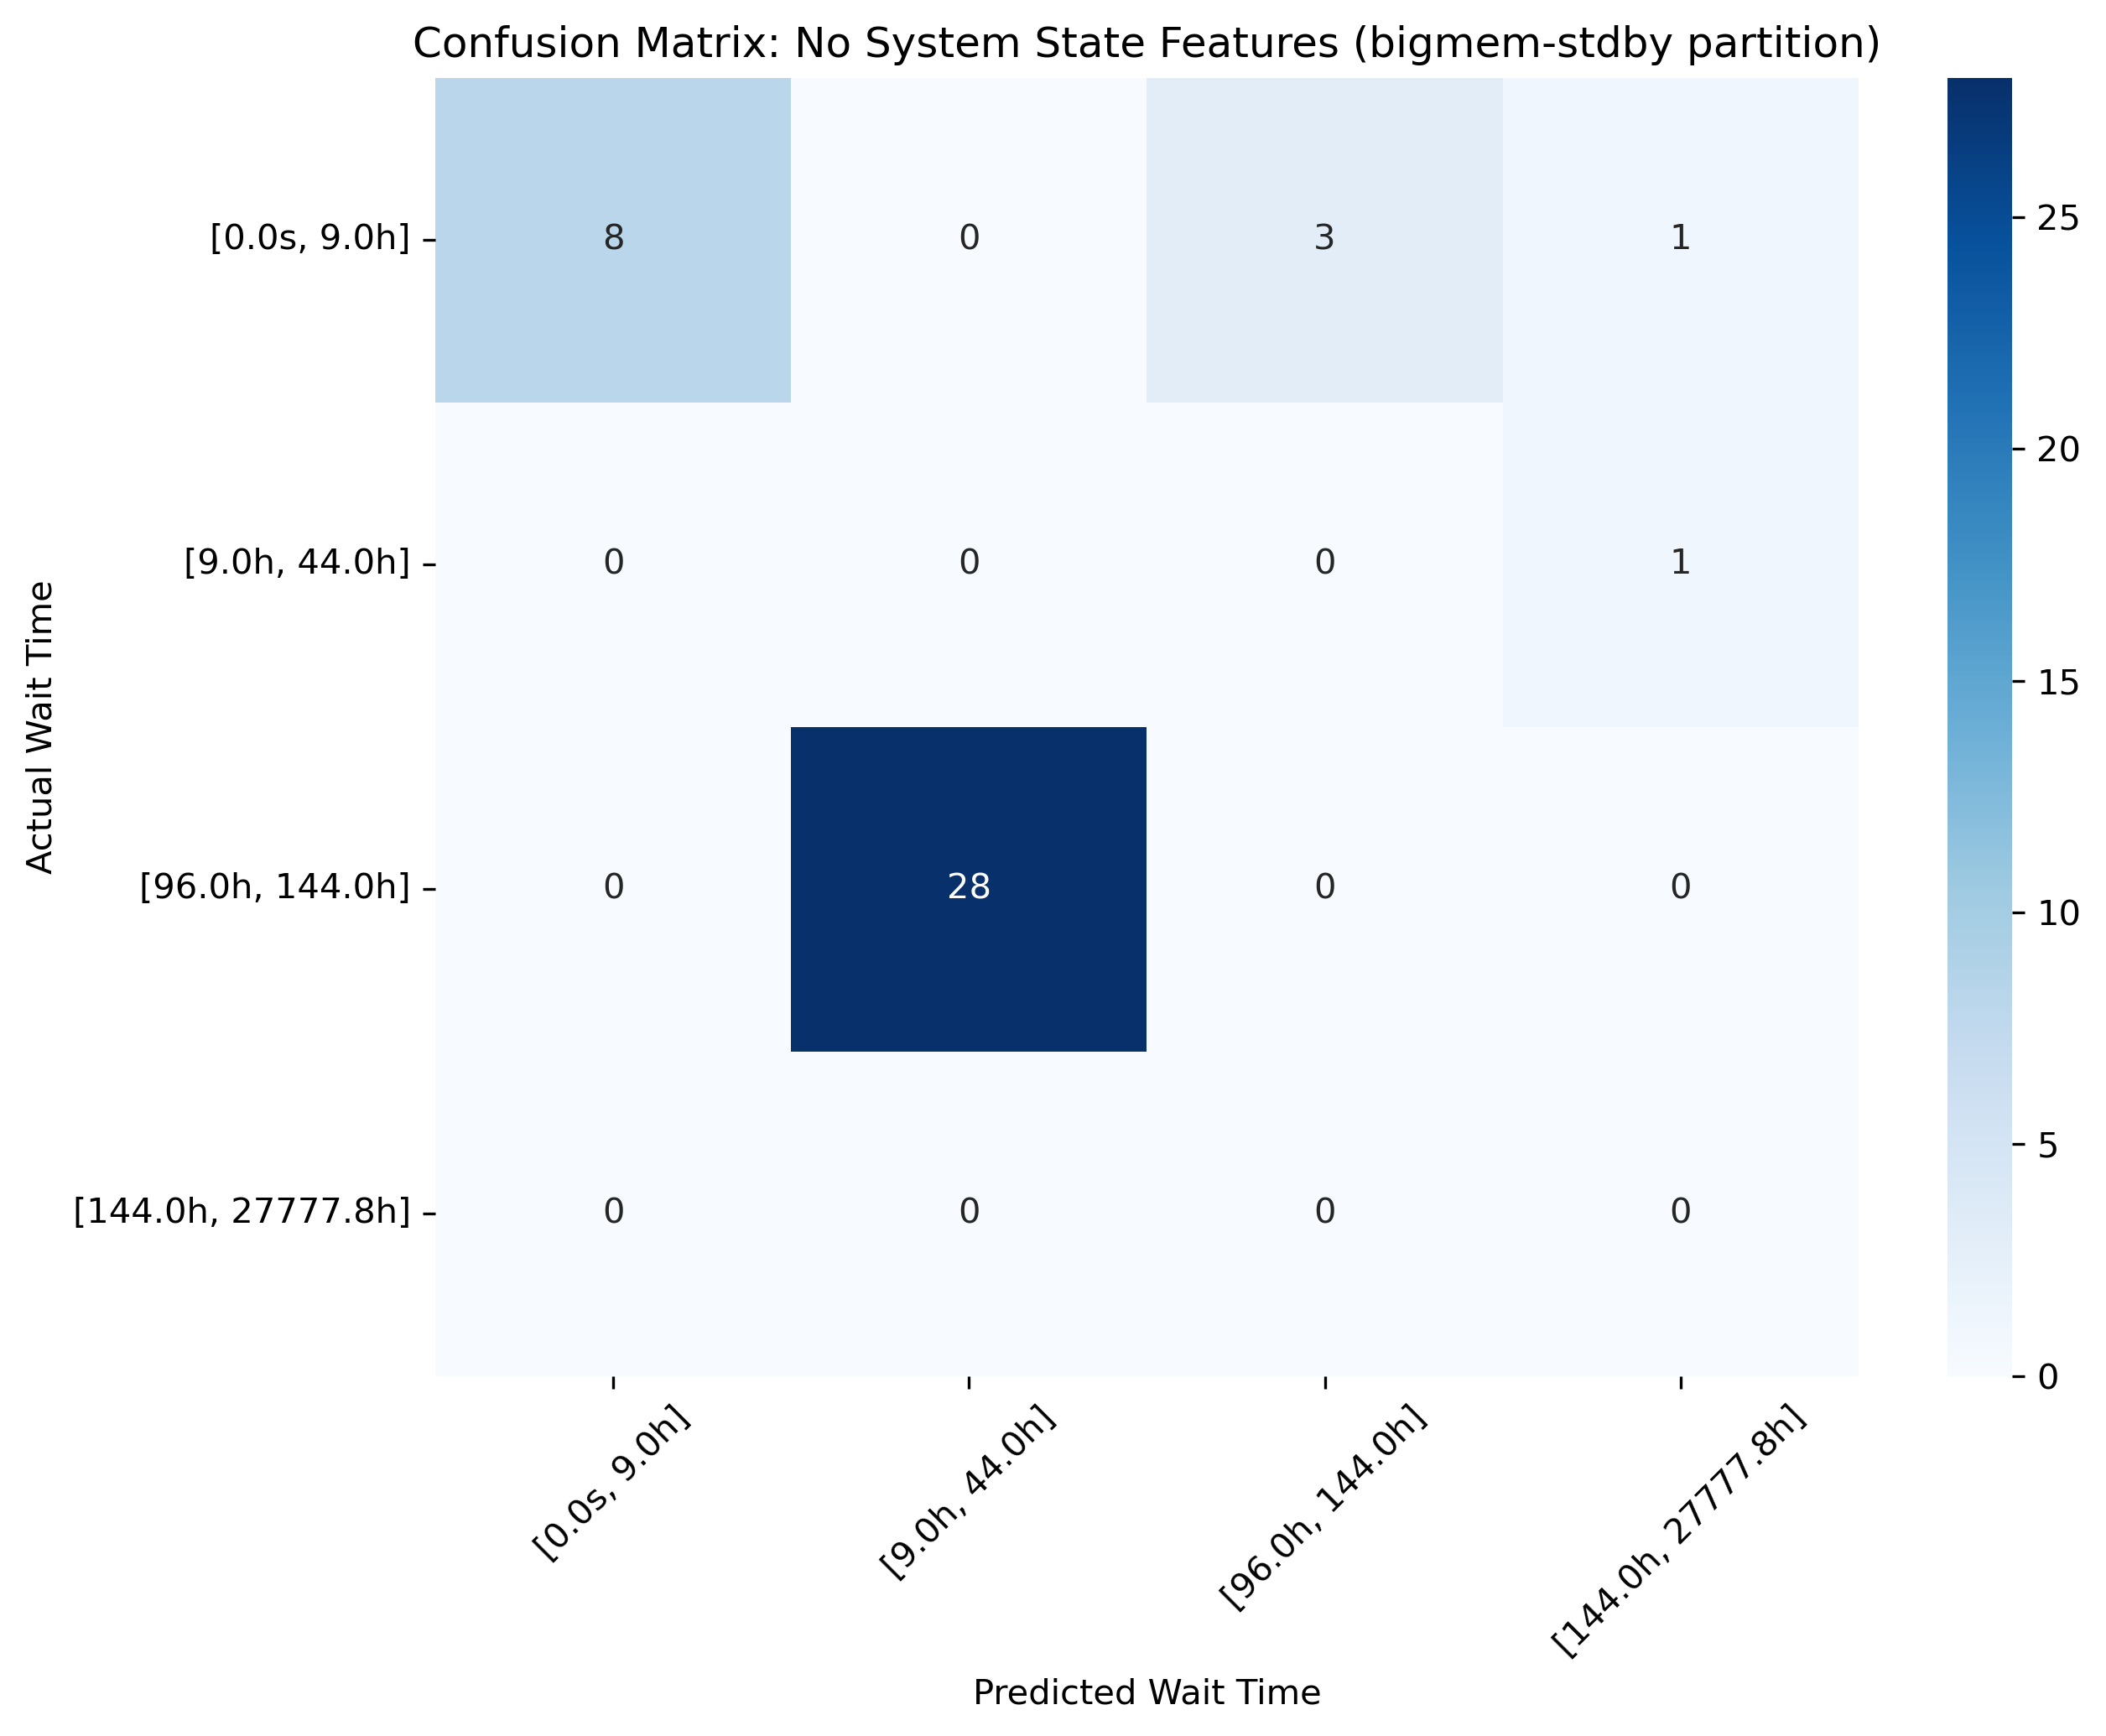

In [6]:
for partition in results_df.partition.unique():
    clusters = partition_clusters[partition]
    
    partition_df = results_df[(results_df.partition == partition) & (~results_df.cluster_pred.isna())]
    cluster_instances = set(partition_df['cluster'].unique()).union(set(partition_df['cluster_pred'].unique()))
    labels = [f'[{f"{cluster["min"]:.1f}"+'s' if cluster["min"] < 60 else f"{cluster["min"]/60:.1f}"+'m' if cluster["min"] < 3600 else f"{cluster["min"]/3600:.1f}"+'h'}, {f"{cluster["max"]:.1f}"+'s' if cluster["max"] < 60 else f"{cluster["max"]/60:.1f}"+'m' if cluster["max"] < 3600 else f"{cluster["max"]/3600:.1f}"+'h'}]' for i, cluster in clusters.items() if i in cluster_instances]
    cm = confusion_matrix(partition_df['cluster'], partition_df['cluster_pred'])

    try:
        plt.figure(figsize=(9,7), dpi=300)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Wait Time')
        max_tick = (len(labels)) * 1 + .5
        plt.xticks(ticks=np.arange(.5,max_tick,1), labels=labels, rotation=45)
        plt.yticks(ticks=np.arange(.5,max_tick,1), labels=labels, rotation=0)
        plt.ylabel('Actual Wait Time')
        plt.title(f'Confusion Matrix: No System State Features ({partition} partition)')
        plt.tight_layout()
        plt.show()
    except ValueError as ve:
        print(ve)
        print(f'No data for {partition} partition.')